# Error potential detection based on CNNs with applications on BCI systems

Master thesis in Biomedical Engineering developed by **Rafael Correia**.

Contact me by [email](mailto:jose.rafael1997@hotmail.com). For other projects check my [LinkedIn](https://www.linkedin.com/in/joserafaelcorreia/) and [GitHub](https://github.com/LeafarCoder/) pages.

---

Supervisors:
* Prof. Luca Mainardi
* Prof. João Sanches
* PhD student Davide Marzorati

---

Project launch: March 2020

Last update: July 2020

---

## Implementation notes

All the available code is in accordance with Python 3 version.

This notebook is organized in the following Sections:

1. Setup
  
  1.1. Necessary installs

  1.2. Necessary imports

  1.3. Auxiliary functions

  1.4. Mount Google Drive


2. Process dataset

  2.1. Define files and channels

  2.2. Convert raw data (...)

  2.3. Preprocess data

  2.4. Epoching data

  2.5. Data inspection

3. CNN model
  * Define model

  * Train model

  * Test model

  * Save model

Further details are provided in respective Sections.

## 1\. Setup
---
---
1.1. Necessary installs

  * When running the notebook in Colab, the installs will have to be run everytime a new session starts. **After installation restart the runtime** as suggested at the output.
  * If running it locally the install will be permanent.

---

1.2. Necessary imports

  * Import needed libraries for:
    * Data storage
    * Deep learning
    * Signal processing
    * Extra functionality
    * Google Colab & PyDrive
  * If "No module named 'module_name' " error occurs check if the module is installed. If not, add it in the **Necessary installs** to be installed.

---

1.3. Auxiliary functions

  * Define basic functionality for the next Sections:
    * File management (save, open, search, ...)
    * Data processing (filters, ...)
    * Miscellaneous

---

1.4. Define project directories
  
  * If notebook is being run *online*:
    * Associate a Google Drive account with the current Google Colab session. This allows to access files (such as databases) and store results. After mounting the Google Drive, its contents will be available for the whole duration of the session.
  
  * If notebook is being run *offline*:
    * Just define the *project_root_folder* on local computer.

  * All other paths to navigate the project folders are automatiacally defined from the parent *project_root_folder*.
    * For that to run error-free, please keep a folder tree structure similar to the one presented in detail in the this Section.

### 1.1\. Necessary installs

In [ ]:
# If the following packages are not installed, then do it.
# Otherwise, no need to run this cell.

# Prevent output (if output for debugging is desired comment the line):
%%capture

# Install PyDrive
!pip install PyDrive

# Install Comet
!pip install comet_ml==3.1.12
# to update dependencies: !pip3 install comet_ml --upgrade --upgrade-strategy eager

# Uncomment if TPU is desired (install before Pytorch Lightning)
# To use TPU: Click Runtime > Change runtime settings. Select Python 3, and hardware accelerator “TPU”. This will give you a TPU with 8 cores.
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

# Install PyTorch Lightning
!pip install pytorch-lightning==0.9.0

# Restart Google Colab session (ignore error)
import os
os.kill(os.getpid(), 9)

### 1.2\. Necessary imports

In [1]:
# Data storage
import pandas as pd
import numpy as np
import pickle as pk
import csv

# Deep learning libraries
from comet_ml import Experiment   # import 'comet_ml' before 'torch'
import pytorch_lightning as pl
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
import tensorflow as tf

# Signal processing
from scipy.signal import butter, sosfreqz, sosfiltfilt

# Support libraries
import time
import datetime
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
import re
import json
from tqdm import tqdm
from termcolor import colored
from IPython.display import clear_output
import importlib
import textwrap

# System operations
import sys
import os

# Google Colab & PyDrive
from google.colab import files
from google.colab import auth
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

### 1.3\. Auxiliary functions

In [2]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++ File management ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# --------------------------------------------------------------------------------------------
# -------- Serialize and save the 'data' variable into the specified path --------------------
# --------------------------------------------------------------------------------------------
def save_file_pickle(data, path, force_overwrite=False, print_state=True):
  if(os.path.exists(path)):
    if(force_overwrite):
      reply="y"
    else:
      reply = str(input("File \"{}\" already exists!\nDo you want to overwrite it? (y/n):\n".format(os.path.basename(path)))).lower().strip()

    if reply == "y":
      with open(path,"wb") as f:
        pk.dump(data, f)
        if(print_state):
          print("File successefully saved!")
    else:
      if(print_state):
        print("File not saved!")
  else:
    with open(path,"wb") as f:
      pk.dump(data, f)
      if(print_state):
        print("File successefully saved!")

# --------------------------------------------------------------------------------------------
# ------ Open the file at the specified path, un-serialize the data and return it ------------
# --------------------------------------------------------------------------------------------
def open_file_pickle(path):
  if(os.path.exists(path)):
    with open(path,"rb") as f:
      return pk.load(f)
      print("File \"{}\" uploaded successfully!".format(os.path.basename(path)))
  else:
    print("File \"{}\" does not exist!".format(os.path.basename(path)))

# --------------------------------------------------------------------------------------------
# -------------------- Get available Pickle folder in the specified path ---------------------
# --------------------------------------------------------------------------------------------
def get_available_pickle_folders(path, folder_type="", available_files=[], available_files_types=[]):
  for folder in os.listdir(path):
    if os.path.isdir(path+folder):
      available_files_types.append("   > {}\t\t{}\t{} (directory)\n".format(len(available_files), folder_type, folder))
      available_files.append(path+folder+"/")
    else:
      available_files_types.append("   > {}\t\t{}\t{} (file)\n".format(len(available_files), folder_type, folder))
      available_files.append(path+folder)


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Pre-processing ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# --------------------------------------------------------------------------------------------
# ------- Perform a Butterworth bandpass filter (forward-backward filter (sosfiltfilt)) ------
# --------------------------------------------------------------------------------------------
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4, axis=-1):
  # Correct for forward-backward filtering (doubles the order)
  order = math.floor(order/2)
  # Design
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  sos = butter(order, [low, high], btype='band', output='sos')
  # Perform a forward-backward filter: removes phase shift and doubles order of filter
  return sosfiltfilt(sos, data, axis=axis)


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Miscellaneous ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# --------------------------------------------------------------------------------------------
# ------------------------------ Prints error in formated way --------------------------------
# --------------------------------------------------------------------------------------------
def print_error(error_msg, traceback_function=None):
  print(colored('-'*75,'red'))
  if(traceback_function==None):
    print(colored('ERROR:','red'))
  else:
    print(colored('ERROR in {}:'.format(traceback_function),'red'))
  print(colored('\t>> {}'.format(error_msg), 'red'))
  print(colored('-'*75,'red'))

# --------------------------------------------------------------------------------------------
# ------------------------------ Prints warnings in formated way -----------------------------
# --------------------------------------------------------------------------------------------
def print_warning(warning_msg, traceback_function=None):
  print(colored('-'*75,'yellow'))
  if(traceback_function==None):
    print(colored('WARNING:','yellow'))
  else:
    print(colored('WARNING in {}:'.format(traceback_function),'yellow'))
  print(colored('\t>> {}'.format(warning_msg), 'yellow'))
  print(colored('-'*75,'yellow'))

# --------------------------------------------------------------------------------------------
# -------------------------- Convert metadata dictionary to string ---------------------------
# --------------------------------------------------------------------------------------------
def processing_metadata2str(metadata, style="line"):
  # Styles: 'line' or 'block'

  # Final string
  ans = ""
  spacing = ""
  if(style == 'line'):
    spacing = "; "
  elif(style == 'block'):
    spacing = '\n'
  
  # Bandpass filter
  if('bandpass_filter' in metadata):
    bp = metadata['bandpass_filter']
    ans += "Bandpass[from {}Hz to {}Hz, order:{}]{}".format(bp['low_freq'], bp['high_freq'], bp['order'], spacing)

  # Noise reduction
  if('noise...' in metadata):
    noise = metadata['noise...']
    ans += "Noise[...{}...{}]{}".format(noise['...1'], noise['...2'], spacing)
    if(style == 'block'):
      ans += '\n'

  # Remove last spacing
  ans = ans[:-len(spacing)]

  return ans

# --------------------------------------------------------------------------------------------
# ---------------------- Convert metadata dictionary to directory path -----------------------
# --------------------------------------------------------------------------------------------
def metadata2path_code(filt_metadata={}, epoch_metadata={}, bal_metadata={}):
  # Final string
  ans = ""
  spacing = "_"
  
  # If not processing was done
  if(not filt_metadata):
    #ans += "noPreProcessing{}".format(spacing)
    ans += "raw{}".format(spacing)

  # ++++++++++++++++++++ Filter metadata ++++++++++++++++++++
  # Bandpass filter
  if('bandpass_filter' in filt_metadata):
    bp = filt_metadata['bandpass_filter']
    ans += "bp[low:{},high:{},ord:{}]{}".format(bp['low_freq'], bp['high_freq'], bp['order'], spacing)

  # Noise reduction
  if('noise...' in filt_metadata):
    noise = filt_metadata['noise...']
    ans += "Noise[...{}...{}]{}".format(noise['...1'], noise['...2'], spacing)
  
  # Channel selection
  if('channel_selection' in filt_metadata):
    channel_selection = filt_metadata['channel_selection']
    exclude_channels = channel_selection['exclude_channels']
    include_channels = channel_selection['include_channels']
    num_channels = channel_selection['num_channels']
    txt = "cs[#:{},".format(num_channels)
    if(exclude_channels):   # If this dictionary is not empty
      # 'all\{ch1,ch2,...} meaning the considered channels are all except ch1, ch2, ...
      txt += "all\\{{{}}}]{}".format(','.join(exclude_channels), spacing)
    elif(include_channels):
      txt += "{{{}}}]{}".format(','.join(include_channels), spacing)
    ans += txt
    
  # ++++++++++++++++++++ Epoch metadata ++++++++++++++++++++
  if(epoch_metadata):
    ans += "epoch[onset:{},size:{}]{}".format(epoch_metadata['fb_windowOnset'], epoch_metadata['fb_windowSize'], spacing)

  # ++++++++++++++++++++ Balanced metadata ++++++++++++++++++++
  if(bal_metadata):
    ans += "bal[added_to:{},#:{}]{}".format(bal_metadata['added_to_class'], bal_metadata['clones_added'], spacing)

  # Remove last spacing
  ans = ans[:-len(spacing)]

  return ans

# --------------------------------------------------------------------------------------------
# ---------------------- Convert data and metadata into data description ---------------------
# --------------------------------------------------------------------------------------------
def print_data_descriptions(data, data_labels, filt_meta={}, epoch_meta={}, bal_meta={}):

  subjects = np.unique(data_labels[:,0])
  sessions = np.unique(data_labels[:,1])
  runs = np.unique(data_labels[:,2])
  data_size = data.shape
  positive_feedbacks = np.count_nonzero(data_labels[:,4] == 1)
  negative_feedbacks = np.count_nonzero(data_labels[:,4] == 0)

  text = ""

  # Text structure
  '''
  Subjects (#...):
    ...,...,...
  Number of sessions per subject: ...
  Data size (trials, channels, time samples): (...,...,...)

  Positive feedbacks: ...
  Negative feedbacks: ...

  Pre-processing:
    Bandpass:
      Low freq.:
      High freq.:
      Filter order:

    Channel selection
      Number of channels:
      Channels:

  Epoching:
    Onset time (ms): ...
    Window size (ms): ...
  '''

  phisio_channel_names = ["Fp1","AF7","AF3","F1","F3","F5","F7","FT7","FC5","FC3","FC1","C1","C3","C5","T7","TP7","CP5","CP3","CP1","P1","P3","P5","P7","P9","PO7","PO3","O1","Iz","Oz","POz","Pz","CPz","Fpz","Fp2","AF8","AF4","AFz","Fz","F2","F4","F6","F8","FT8","FC6","FC4","FC2","FCz","Cz","C2","C4","C6","T8","TP8","CP6","CP4","CP2","P2","P4","P6","P8","P10","PO8","PO4","O2"]

  # Main descriptors
  title = "General"
  padding = (75 - len(title)) // 2
  text += "{} {} {}\n\n".format("-"*padding, title, "-"*padding)
  text += "Subjects ({}):\n\t{}\n\n".format(len(subjects), '\n\t'.join(textwrap.wrap(', '.join(str(s) for s in subjects), width=100)))
  text += "Number of sessions per subject: {}\n\n".format(len(sessions))
  text += "Number of runs per session: {}\n\n".format(len(runs))
  text += "Data size\n"
  text += "\tTrials: \t{}\n".format(data_size[0])
  text += "\tChannels: \t{}\n".format(data_size[1])
  text += "\tTime samples: \t{}\n\n".format(data_size[2])
  text += "Positive feedbacks: \t{}\n".format(positive_feedbacks)
  text += "Negative feedbacks: \t{}\n".format(negative_feedbacks)
  text += "Total feedbacks: \t{}\n\n".format(positive_feedbacks + negative_feedbacks)
  if(not 'channel_selection' in filt_meta):
    text += "Channels:\n\t{}\n\n".format('\n\t'.join(textwrap.wrap(', '.join(phisio_channel_names), width=100)))

  # Pre-processing
  if(filt_meta):
    title = "Pre-processing"
    padding = (75 - len(title)) // 2
    text += "{} {} {}\n\n".format("-"*padding, title, "-"*padding)

    # Bandpass
    if('bandpass_filter' in filt_meta):
      bp = filtered_metadata['bandpass_filter']
      text += "Bandpass:\n"
      text += "\tLow freq.: {} Hz\n".format(bp['low_freq'])
      text += "\tHigh freq.: {} Hz\n".format(bp['high_freq'])
      text += "\tFilter order: {}\n\n".format(bp['order'])
    
    # Channel selection
    if('channel_selection' in filt_meta):
      cs = filt_meta['channel_selection']
      # Check which channels are available
      if(cs['include_channels']):
        phisio_channel_names = [ch for ch in cs['include_channels']]
      elif(cs['exclude_channels']):
        phisio_channel_names = [ch for ch in phisio_channel_names if ch not in cs['exclude_channels']]

      text += "Channel selection:\n"
      text += "\tNumber of channels: \t{}\n".format(len(phisio_channel_names))
      text += "\tChannels: \t{}\n\n".format(', '.join(phisio_channel_names))

  # Epoching
  if(epoch_meta):
    title = "Epoching"
    padding = (75 - len(title)) // 2
    text += "{} {} {}\n\n".format("-"*padding, title, "-"*padding)
    text += "Onset time: \t{} ms\n".format(epoch_meta['fb_windowOnset'])
    text += "Window size: \t{} ms\n\n".format(epoch_meta['fb_windowSize'])

  # Balancing
  if(bal_meta):
    title = "Balancing"
    padding = (75 - len(title)) // 2
    text += "{} {} {}\n\n".format("-"*padding, title, "-"*padding)
    # Keep definition: class/label 0 is the ErrP; class/label 1 is No ErrP
    if(bal_meta['added_to_class'] == 0):
      text += "Added to class with less trials: \tErrP (negative feedback)\n"
    elif(bal_meta['added_to_class'] == 1):
      text += "Added to class with less trials: \tNo ErrP (positive feedback)\n"
    text += "Number of replicated trials: \t\t{} ({} times the original size)\n".format(bal_meta['clones_added'], round(bal_meta['replicate_fold'],1))

  return text

### 1.4\. Define project directories

In [3]:
running_online = True

# \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# \\\\\\\\\\\\\\\\\\\\\\\\ IF RUNNING ONLINE \\\\\\\\\\\\\\\\\\\\\\\\\\
# \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# ++++++++++++++++++ Mount Google Drive ++++++++++++++++++
# If running the notebook in some server (like Google Colab), then we will need
# to connect it to some drive from which to download the dataset.
# After running this cell, access the given URL and choose your desired Drive.
# Accept the terms and conditions, copy the authorization code to the prompt and press <Enter>
if(running_online):
  drive.mount('/content/drive')

# \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# \\\\\\\\\\\\\\\\\\\\\\\\ IF RUNNING LOCALLY \\\\\\\\\\\\\\\\\\\\\\\\\
# \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# If the notebook is being run locally, i.e., not in a server,
# then download or create the directory structure presented below and just change
# the project root folder variable below.



# ++++++++++++++++++ Define drive directories ++++++++++++++++++
# Change the directories accordingly

# Please, keep the following project organization:
#
# _root
# ├── _Datasets
# |   ├── _Dataset_name_1
# |   |   └── ...
# |   |
# |   └── _Dataset_name_2
# |       └── ...
# |
# ├── _Images
# |   ├── _Pre-processing
# |   |   ├── image1.png
# |   |   └── ...
# |   └── ...
# |
# ├── _Models
# |   ├── _Model Classes
# |   |   ├── model_class_1
# |   |   └── ...
# |   └── _Model Saves
# |       ├── model_save_1
# |       └── ...
# |
# └── comet_ml_config.p

# The Dataset sub-folder organization will depend on the type of data.
# For this project, we organize it as follows:

# _Datasets
# └── _BCI_Challenge_NER_2015
#     ├── AllLabels.csv
#     ├── ChannelsLocation.csv
#     ├── _all
#     |   ├── Data_S01_Sess01.csv
#     |   ├── Data_S01_Sess02.csv
#     |   ├── ...
#     |   ├── Data_S26_Sess04.csv
#     |   └── Data_S26_Sess05.csv
#     |
#     └── _Dataset_pickle_files
#         ├── _Raw
#         |   ├── Data_S01_Sess01.p
#         |   ├── ...
#         |   └── Data_S26_Sess05.p
#         |
#         ├── _Pre-processed
#         |   ├── _Pre-proc_1
#         |   |   ├── Data_S01_Sess01.p
#         |   |   ├── ...
#         |   |   └── Data_S26_Sess05.p
#         |   |
#         |   ├── _Pre-proc_2
#         |   |   └── ...
#         |   |
#         |   └── ...
#         |
#         ├── _Epoched
#         |   ├── epoched_1.p
#         |   ├── epoched_2.p
#         |   └── ...
#         |    
#         └── _Balanced
#             ├── balanced_1.p
#             └── ...

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++ CHANGE ROOT HERE +++++++++++++++++++++++++++
# Set the main folder (root)
project_root_folder = "/content/drive/My Drive/Tese BCI/"
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Where the different CNN models are stored
project_models_folder = project_root_folder + "Models/"
# Model Classes contain the code that constitute each model
project_model_classes_folder = project_models_folder + "Model Classes/"
# Model Saves contain the final trained models
project_model_saves_folder = project_models_folder + "Model Saves/"

# Dataset folder
project_dataset_folder = project_root_folder + "Datasets/Monitoring_error-related_potentials_2015/"
# Folder where different levels of precessed data is stored (raw, pre-processed, epoched)
project_dataset_pickle_folder = project_dataset_folder + "Datasets_pickle_files/"
project_preprocessed_folder = project_dataset_pickle_folder + "Pre-processed/"
project_epoched_folder = project_dataset_pickle_folder + "Epoched/"
project_balanced_folder = project_dataset_pickle_folder + "Balanced/"
project_raw_folder = project_dataset_pickle_folder + "Raw/"

# Local dataset folders
local_dataset_train_folder = project_dataset_folder + "train/"
local_dataset_test_folder = project_dataset_folder + "test/"
local_dataset_all_folder = project_dataset_folder + "all/"  # folder with both 'test' and 'train'


Mounted at /content/drive


## 2\. Process dataset

##### In this Section, the dataset is processed before being fed to the Deep Learning Neural Network. It is organized in a modular fashion, where the following steps are all done in separate stages:
  
  1. Convert original dataset file format to Pickle file format.
  2. Pre-process data
  3. Epoch data

This increases code readability and testing speed (in the case where only a subset of these operations is needed).

[Pickle](https://docs.python.org/3/library/pickle.html) is a Python library that allows serialization of variables and storing them as files.

**Step 1.** only needs to be executed once and it will store each data file as a Pickle file in a folder folder called *Raw* (check the project directory tree structure in **1.4. Mount Google Drive**).

**Step 2.** will process each file and store it in a folder whose name is defined by the type of processing performed, i.e., a short description of the processing the data underwent. As an example consider the folder name *bp[low:1,high:10,ord:6]_cs[#:2,{CPz,Cz}]*. It refers to the following processing:
  * *bp[low:1,high:10,ord:6]*
    * A 6th order bandpass filter from 1Hz to 10Hz
  * *cs[#:2,{CPz,Cz}]*
    * Channel selection: 2 channels (CPz and Cz)

**Step 3.** epochs the data, i.e., keeps only the relevant data which is contained in the time windows of interest. In our case, the signal during feedback presentation.

---
---

2.1. Define files and channels

  * In this sub-section, the number of subjects and sessions is defined, as well as the file names for the dataset (each file contains data from one session of a particular subject).
  * The channels are also defined. A hash map is created to easily associate a channel with its corresponding index in the data. Channel names follow the usual convention (some examples: *Fp1,Fp2,AF7,AF3,AF4*, ...). Besides all phisiological signals (EEG and EOG) two more channels are added: *time* and *feedback*.
---
2.2. Convert raw data
  * Open each file defined in **2.1.** using Pandas for increased load speed (compared with Numpy). The dataset used in this project sotred the data using .csv files with ~100Mb each.
  * Although the data is loaded into memory using Pandas data structure, it is converted to Numpy right away since this library is optimized for mathematical operation (needed during pre-processing).
  * The loaded variable is then serialized and stored as a Pickle file.
---
2.3. Pre-process data

  * Each Pickle file is loaded and all the pre-processing operations are performed for each Numpy 2D array session (filtering, noise removal, channel selection, etc...)
  * The resulting data is serialized again together with a variable containing metadata regarding the pre-processing performed (*filtered_metadata*).
---
2.4. Epoching data

  * Start by defining the window of interest: where does it start (using as a reference the start of feedback which corresponds to 0 miliseconds) and how long is it (both variables in miliseconds).
  * After defining the window, the data is epoched and each trial (they all share the same size) is stacked creating a 3D Numpy tensor where each dimension corresponds to **trial number**, **time** and **channel**.
  * This tensor is serialized and stored with Pickle again.
---
2.5. Data inspection

  * After processing, it is always useful to check the data. This might save us some work when problems start to show up ahead due to some unseen bug in the data.
  * Both data description and plots are available.

---
### Note:
Directory management is taken care for you. The user only needs to select the folders or files (from a prompt, not in the code!) from which the data must be loaded.

Files saving is done with automatic naming (based on the processing performed on the data) and organized into the correct folders for you as well.

### 2.1\. Define files and channels

In [ ]:

# ++++++++++++++++++ Define subjects and sessions ++++++++++++++++++

# Index of training subjects
subjects_idx = range(1,7)  # subjects 1,2,3,4,5,6
#subjects_idx = range(1,10)
subjects = [format(s,'02') for s in subjects_idx]

# Index of training sessions
sessions_idx = range(1,3) # sessions 1,2
sessions = [format(s,'01') for s in sessions_idx]

# Index of training runs
runs_idx = range(1,11) # sessions 1,2,...,10
runs = [format(s,'01') for s in runs_idx]

# List with data files names
file_names = ["Subject" + subject + "_s" + session + "_run" + run
              for subject in subjects
              for session in sessions
              for run in runs]

# ++++++++++++++++++ Create electrodes map ++++++++++++++++++

# Create map between electrode labels and indexes
# Include all 64 electrodes, plus Feedback and Time
channel_names = ["Time","Fp1","AF7","AF3","F1","F3","F5","F7","FT7","FC5","FC3","FC1","C1","C3","C5","T7","TP7","CP5","CP3","CP1","P1","P3","P5","P7","P9","PO7","PO3","O1","Iz","Oz","POz","Pz","CPz","Fpz","Fp2","AF8","AF4","AFz","Fz","F2","F4","F6","F8","FT8","FC6","FC4","FC2","FCz","Cz","C2","C4","C6","T8","TP8","CP6","CP4","CP2","P2","P4","P6","P8","P10","PO8","PO4","O2","Feedback"]
num_channels = len(channel_names)
channel_indexes = np.arange(0, len(channel_names))
channels_name2idx = dict(zip(channel_names, channel_indexes))

# Do same but only for phisiological signals (used when 'Time' and 'Feedback' are separated from data)
phisio_channel_names = ["Fp1","AF7","AF3","F1","F3","F5","F7","FT7","FC5","FC3","FC1","C1","C3","C5","T7","TP7","CP5","CP3","CP1","P1","P3","P5","P7","P9","PO7","PO3","O1","Iz","Oz","POz","Pz","CPz","Fpz","Fp2","AF8","AF4","AFz","Fz","F2","F4","F6","F8","FT8","FC6","FC4","FC2","FCz","Cz","C2","C4","C6","T8","TP8","CP6","CP4","CP2","P2","P4","P6","P8","P10","PO8","PO4","O2"]
num_phisio_channels = len(phisio_channel_names)
phisio_channel_indexes = np.arange(0, len(phisio_channel_names))
phisio_channels_name2idx = dict(zip(phisio_channel_names, phisio_channel_indexes))

### 2.2\. Convert raw data

Raw data is converted from Comma Separated Value files (.csv) files into Pickle files (.p)

#### Get labels

In [ ]:
# Load test and training labels
load_labels = pd.read_csv(project_dataset_folder + "AllLabels.csv").to_numpy()

# Reformat the data:
# [Subject, Session, Run, Trial#, Feedback_type] (Feedback type: 1 for Positive (noErrP); 0 for Negative (ErrP))
# all_labels =  [[2,1,1,1,1],
#                [2,1,1,2,0],
#                [..., ...]]
all_labels = []
for label in load_labels:
  # Get Subject, Session and Feedback number
  trial_metadata = [int(s) for s in re.split('(\d+)',label[0]) if s.isdigit()]
  all_labels.append(np.concatenate([trial_metadata, label[1]], axis=None))
all_labels = np.array(all_labels)

# Keep only labels for selected subjects and sessions
labels = []
for subj in subjects_idx:
  subj_mask = all_labels[:,0]==subj
  for sess in sessions_idx:
    sess_mask = all_labels[:,1]==sess
    idxs = np.where(subj_mask & sess_mask)[0]
    labels.append(all_labels[idxs])
labels = np.array(np.concatenate(labels))

In [ ]:
'acc' + str(2)

'acc2'

#### Get and save raw data
Serialize and save data collection as Pickle file


In [ ]:
for file in tqdm(file_names,unit="file"):
    # File name
    file_path = local_dataset_all_folder + file + ".csv"
    file_sub_sess_run = [int(s) for s in re.split('(\d+)',file) if s.isdigit()]
    # Read file and convert to Numpy (transpose to put Channels in the first axis and Time in the second axis)
    new_sess = pd.read_csv(file_path).to_numpy().transpose()
    # Get labels for this session: [trial#, feedback]
    this_indexes = np.where((labels[:,0]==file_sub_sess_run[0]) & (labels[:,1]==file_sub_sess_run[1]) & (labels[:,2]==file_sub_sess_run[2]))[0]
    this_labels = labels[this_indexes, 3:]
    # Get feedback indexes
    fb_indexes = np.where(new_sess[channels_name2idx.get('Feedback'),:] == 1)[0]   # time points where feedback is presented
    # Save as Pickle file
    save_path = project_raw_folder + file + ".p"
    save_file_pickle((new_sess,file_sub_sess_run, this_labels, fb_indexes), save_path, force_overwrite=True, print_state=False)

100%|██████████| 120/120 [08:13<00:00,  4.11s/file]


### 2.3\. Pre-process data

#### Apply pre-processing

In [ ]:
# ++++++++++++++++++ Define processing characteristics ++++++++++++++++++
#@markdown # Pre-processing
#@markdown ---

# Remove non phisiological signals (time and feedback)
non_phisiological = {'Time', 'Feedback'}
phisiological_indexes = np.sort([channels_name2idx.get(channel) for channel in channel_names if channel not in non_phisiological])

# Sampling frequency (Hz)
fs = 512

# Bandpass filter characteristics
#@markdown ### Bandpass filter:
apply_bandpass = True #@param {type:"boolean"}
bandpass_order = 6 #@param {type:"slider", min:2, max:10, step:2}
# Bandpass limits (Hz)
bandpass_low_freq = 1 #@param {type:"number"}
bandpass_high_freq = 10  #@param {type:"number"}
bandpass_metadata = {'low_freq': bandpass_low_freq, 'high_freq': bandpass_high_freq, 'fs': fs, 'order': bandpass_order}
#@markdown ---

# Principal Component Analysis
# ...

# Noise removal
# ...

# Channel selection
#@markdown ### Channel selection:
# Use only one of the two methods (include or exclude): Leave one of the dictionaries empty!
apply_channel_selection = True #@param {type:"boolean"}
#@markdown * Define the channels in the code
exclude_channels = {}
include_channels = {'FCz','Cz'}
if(exclude_channels):   # If cexlude_channels is not empty
  num_channels = len(phisio_channel_names) - len(exclude_channels)
elif(include_channels):  # If cexlude_channels is not empty
  num_channels = len(include_channels)
channel_selection = {'exclude_channels': exclude_channels, 'include_channels': include_channels, 'num_channels': num_channels}
#@markdown ---

# Store metadata related to the filtering process applied (for later reference)
filtered_metadata = {}
# Add metadata elements
if(apply_bandpass):
  filtered_metadata.update({"bandpass_filter": bandpass_metadata})
if(apply_channel_selection):
  filtered_metadata.update({"channel_selection": channel_selection})

# Folder name where to store the pre-processed data
folder_name = metadata2path_code(filtered_metadata) + "/"
save_path = project_preprocessed_folder + folder_name
# If folder does not exist, make one
if(not os.path.exists(save_path)):
  os.makedirs(save_path)
print("Saving to {}\n".format(folder_name), flush=True)

# ++++++++++++++++++ For each Session apply the filtering ++++++++++++++++++

for idx, file_name in enumerate(tqdm(file_names,unit='file')):
  # Load raw data from Raw folder
  (session, file_sub_sess, sess_labels, fb_indexes) = open_file_pickle(project_raw_folder + file_name + ".p")

  # ------------------------ Remove non phisiological signals ------------------------
  session = session[phisiological_indexes,:]

  # ------------------------ Bandpass filter ------------------------
  if(apply_bandpass):
    session = butter_bandpass_filter(session, bandpass_low_freq, bandpass_high_freq, fs, order=bandpass_order, axis=1)

  # ------------------------ Noise reduction ------------------------
  # ...

  # ------------------------ Channels selection ------------------------
  if(apply_channel_selection):
    # Use one of the following methods: exclusion or inclusion
    if(exclude_channels):     # If dictionary is not empty: Exclusion criterion
      channels_indexes = np.sort([phisio_channels_name2idx.get(channel) for channel in channel_names if channel not in exclude_channels])
    elif(include_channels):   # If dictionary is not empty: Inclusion criterion
      channels_indexes = np.sort([phisio_channels_name2idx.get(channel) for channel in channel_names if channel in include_channels])
    
    # Keep only the selected channels
    session = session[channels_indexes,:]

  # ------------------------ Save pre-processed data ------------------------
  file_path = save_path + file_name + ".p"
  save_file_pickle((session, file_sub_sess, sess_labels, fb_indexes, filtered_metadata), file_path, force_overwrite=True, print_state=False)

Saving to bp[low:1,high:10,ord:6]_cs[#:2,{Cz,FCz}]/



100%|██████████| 120/120 [03:11<00:00,  1.60s/file]


#### Frequency analysis

In [ ]:
# # Cz electrode
# axes[1, 0].set_title("Cz electrode")
# axes[1, 0].plot(t, Cz_bp, color='C0')
# axes[1, 0].set_xlabel("Time (s)")
# axes[1, 0].set_ylabel("Amplitude")
# # Cz spectrum
# axes[1, 1].set_title("Cz spectrum")
# spectrum_cz, freqs_cz, line = axes[1, 1].magnitude_spectrum(Cz_bp, Fs=1/0.005, scale='dB', color='C0')
# spectrum_cz = spectrum_cz[1:int(len(spectrum_cz)/10)]
# freqs_cz = freqs_cz[1:int(len(freqs_cz)/10)]
# axes[1, 2].plot(freqs_cz, np.log(spectrum_cz)*10, color='C0')
# axes[1, 2].set_title("Cz spectrum (low frequencies)")
# axes[1, 2].set_xlabel("Frequency")
# axes[1, 2].set_ylabel("Magnitude (dB)")

### 2.4\. Epoch data

#### Define parameters and load data

In [ ]:
# ++++++++++++++++++++++++ Define epoching parameters ++++++++++++++++++++++++

# Sampling frequency
fs = 512
# Sets the time shift from feedback stimulus presentation for window start (in miliseconds, negative values for before stimulus)
fb_windowOnset = 0
# Window size to extract from each feedback (in miliseconds, starting on feedback stimulus presentation time + fb_windowOnset)
fb_windowSize = 600
# Corresponding number of samples for window and onset defined above
fb_windowOnsetSamples = int(fb_windowOnset*fs/1000)
fb_windowSizeSamples = int(fb_windowSize*fs/1000)

# ++++++++++++++++++++++++ Initialize variables ++++++++++++++++++++++++
# Store trials. Divide into trials that will have always the same size.
epoched_data = []
# Store trial labels with format: [#subj, #sess, #trial, label]
epoched_data_labels = []
# Store metadata related to the epoching process (window onset, window size, ...)
epoched_metadata = {}
# Add metadata
epoched_metadata['fb_windowOnset'] = fb_windowOnset
epoched_metadata['fb_windowSize'] = fb_windowSize
epoched_metadata['fb_windowOnsetSamples'] = fb_windowOnsetSamples
epoched_metadata['fb_windowSizeSamples'] = fb_windowSizeSamples

# ++++++++++++++++++++++++ Load data ++++++++++++++++++++++++

# Show available files
# Show all files that were stored as Pickle files (Python library to serialize variables)
file_index = -1
available_files = [project_raw_folder]
available_files_types = ["   > {}\t\t{}\t{} (directory)\n".format(0, "Raw\t", "Raw")]
get_available_pickle_folders(project_preprocessed_folder,  "Pre-processed", available_files, available_files_types)
#get_available_pickle_folders(project_epoched_folder,       "Epoched      ", available_files, available_files_types)

while((file_index < 0) | (file_index > len(available_files)-1)):
  # Present choices
  print("     Index\tFolder type\tFolder name:")
  print(''.join(available_files_types))

  # Ask user which file to load:
  file_index = int(input("Folder to load (choose an index from 0 to {}):\n".format(len(available_files)-1)))
  clear_output(wait=True)

# Check if the file corresponds to a processed data file ('pl1': "processing level 1" (processed))
option = "y"
file_type = available_files_types[file_index].split("\t")[2]
if(file_type != "Pre-processed"):
  option = input("\nThe data from this file has not been processed yet. Do you wish to continue? (y/n)\n")
if(option == "y"):
  epoching_file_path = available_files[file_index]
  # Get list of Pickle files in this directory
  pickle_files = [x for x in os.listdir(epoching_file_path) if x.endswith(".p")]
  pickle_files.sort()
else:
  print("Loading canceled!")

     Index	Folder type	Folder name:
   > 0		Raw		Raw (directory)
   > 1		Pre-processed	bp[low:1,high:10,ord:6] (directory)
   > 2		Pre-processed	bp[low:1,high:10,ord:6]_cs[#:2,{Cz,FCz}] (directory)

Folder to load (choose an index from 0 to 2):
1


#### Perform epoching

In [ ]:
# ++++++++++++++++++ For each Session apply the epoching ++++++++++++++++++
for idx, file_name in enumerate(tqdm(pickle_files,unit=' session')):
  # Open pickle file
  load_path = epoching_file_path + file_name

  # Unpack depending on file type:
  if(file_type == "Pre-processed"):
    (session, file_sub_sess_run, run_labels, fb_indexes, filtered_metadata) = open_file_pickle(load_path)
  if(file_type == "Raw"):
    (session, file_sub_sess_run, run_labels, fb_indexes) = open_file_pickle(load_path)
  
  # Get subject and session numbers
  subj = file_sub_sess_run[0]
  sess = file_sub_sess_run[1]
  run = file_sub_sess_run[2]

  # Get list of feedback events at pairs [Feedback_type, Time_sample]
  fb_events = np.array([list(l) for l in zip(run_labels[:,1], fb_indexes)])

  # Append individual trial data
  for trial_idx, (label, trial_index) in enumerate(fb_events):
    # Add data
    idx_start = trial_index + fb_windowOnsetSamples
    idx_end = idx_start + fb_windowSizeSamples
    epoched_data.append(session[:, idx_start:idx_end])
    # Add label (positive or negative feedback)
    epoched_data_labels.append([subj, sess, run, (trial_idx+1), label])

# After all trials have been added, convert it to Numpy
epoched_data = np.array(epoched_data)
epoched_data_labels = np.array(epoched_data_labels)

100%|██████████| 120/120 [02:00<00:00,  1.00s/ session]


#### Save epoched data

In [ ]:
# File name where to store the pre-processed data
file_name = metadata2path_code(filt_metadata=filtered_metadata, epoch_metadata=epoched_metadata) + ".p"
#file_name = metadata2path_code(filt_metadata=filtered_metadata) + ".p"
#file_name = metadata2path_code(epoch_metadata=epoched_metadata) + ".p"
file_name = project_epoched_folder + file_name
# Save
save_file_pickle((epoched_data, epoched_data_labels, filtered_metadata, epoched_metadata), file_name)
print("Saving on "+file_name)
#save_file_pickle((epoched_data, epoched_data_labels, {}, epoched_metadata), file_name)

File successefully saved!
Saving on /content/drive/My Drive/Tese BCI/Datasets/Monitoring_error-related_potentials_2015/Datasets_pickle_files/Epoched/bp[low:1,high:10,ord:6]_epoch[onset:0,size:600].p


### 2.5. Balance dataset

Create one more Processing folder: "Balanced"

On process pipeline: after Epoch, before pre-processing

Given the data label distribution, balance the dataset!

Tasks:
  * Plot histograms with label distribution
  * Provide algorithms to solve it
    * Fill smaller class with random self copies
    * Add small noise to copies? (Not a good idea...)

#### Load data

In [ ]:
# ++++++++++++++++++++++++ Load data ++++++++++++++++++++++++

# Show available files
# Show all files that were stored as Pickle files (Python library to serialize variables)
file_index = -1
available_files = []
available_files_types = []
# Only add Epoched data
get_available_pickle_folders(project_epoched_folder, "Epoched", available_files, available_files_types)

while((file_index < 0) | (file_index > len(available_files)-1)):
  # Present choices
  print("     Index\tFolder type\tFolder name:")
  print(''.join(available_files_types))

  # Ask user which file to load:
  file_index = int(input("Folder to load (choose an index from 0 to {}):\n".format(len(available_files)-1)))
  clear_output(wait=True)

# Check if the file corresponds to a processed data file ('pl1': "processing level 1" (processed))
if(available_files_types[file_index].split("\t")[2] == "Epoched"):
  file_path = available_files[file_index]
  # Get epoched file
  (epoched_data, epoched_data_labels, filtered_metadata, epoched_metadata) = open_file_pickle(file_path)
else:
  print("\nThe data from this file has not been epoched.")

     Index	Folder type	Folder name:
   > 0		Epoched	bp[low:1,high:10,ord:6]_epoch[onset:0,size:800].p (file)
   > 1		Epoched	bp[low:1,high:10,ord:6]_epoch[onset:0,size:1000].p (file)
   > 2		Epoched	bp[low:1,high:10,ord:6]_cs[#:2,{Cz,FCz}]_epoch[onset:0,size:1000].p (file)
   > 3		Epoched	bp[low:1,high:10,ord:6]_cs[#:2,{Cz,FCz}]_epoch[onset:0,size:600].p (file)
   > 4		Epoched	bp[low:1,high:10,ord:6]_cs[#:2,{FCz,Cz}]_epoch[onset:600,size:600].p (file)
   > 5		Epoched	bp[low:1,high:10,ord:6]_epoch[onset:0,size:600].p (file)

Folder to load (choose an index from 0 to 5):
5


#### Create balanced

In [ ]:
# ++++++++++++++++++++++++ Define balancing parameters ++++++++++++++++++++++++

# Get actual number of samples from each class
positive_feedbacks = np.count_nonzero(epoched_data_labels[:,4] == 1)
negative_feedbacks = np.count_nonzero(epoched_data_labels[:,4] == 0)
original_size = 0 # store the original size of the class that will suffer a change

# Calculate unbalance
doBalance = True
diff = positive_feedbacks - negative_feedbacks
add = abs(diff)
if(diff > 0):
  ask = "Positive class has more {} examples than the Negative class.\n".format(add)
  ask += "Clone randomly selected examples from Negative class to match size of Positive class? (y/n)\n"
elif(diff < 0):
  ask = "Negative class has more {} examples than the Positive class.\n".format(add)
  ask += "Clone randomly selected examples from Positive class to match size of Negative class? (y/n)\n"
else:
  print("Dataset is balanced!")
  doBalance = False

if(doBalance):
  ans = input(ask)
  if(ans == 'y'):
    idxs = np.array([])
    if(diff > 0):
      class_idx = 0
      original_size = negative_feedbacks
      if(negative_feedbacks < add):
        class_idxs = np.where(epoched_data_labels[:,4] == class_idx)[0]
        idxs = np.repeat(class_idxs.tolist(), add//negative_feedbacks)
        remain = add % negative_feedbacks
        np.random.shuffle(idxs)
    else:
      class_idx = 1
      original_size = positive_feedbacks
      if(positive_feedbacks < add):
        class_idxs = np.where(epoched_data_labels[:,4] == class_idx)[0]
        idxs = np.repeat(class_idxs.tolist(), add//positive_feedbacks)
        remain = add % positive_feedbacks
        np.random.shuffle(idxs)

    # Select random subset from chosen class
    class_idxs = np.where(epoched_data_labels[:,4] == class_idx)[0]
    
    # Add remaining examples
    idxs = np.concatenate([idxs, random.sample(class_idxs.tolist(), remain)])
    data_clones = epoched_data[idxs]
    data_labels_clones = epoched_data_labels[idxs]
    # Add
    balanced_data = np.concatenate([epoched_data, data_clones])
    balanced_data_labels = np.concatenate([epoched_data_labels, data_labels_clones])

    # ++++++++++++++++++++++++ Initialize variables ++++++++++++++++++++++++
    # Store metadata related to the balancing of the data
    # 'clones_added':   how many trials were added to the class?
    # 'added_to_class': to which class were the trials added? 0:ErrP; 1:NoErrP
    # 'replicate_fold': how many times was the original class size increased by?
    balanced_metadata = {'clones_added': add, 'added_to_class': class_idx, 'replicate_fold': add/original_size}


Positive class has more 3055 examples than the Negative class.
Clone randomly selected examples from Negative class to match size of Positive class? (y/n)
y


#### Save

In [ ]:
# File name where to store the balanced data
file_name = metadata2path_code(filt_metadata=filtered_metadata, epoch_metadata=epoched_metadata, bal_metadata=balanced_metadata) + ".p"
file_name = project_balanced_folder + file_name
# Save
save_file_pickle((balanced_data, balanced_data_labels, filtered_metadata, epoched_metadata, balanced_metadata), file_name)

File successefully saved!


### 2.6\. Data inspection
After processing and epoching and before feeding the data into the model it must be inspected

#### Load data

In [ ]:
# ++++++++++++++++++++++++ Load data ++++++++++++++++++++++++

# Show available files
# Show all files that were stored as Pickle files (Python library to serialize variables)
file_index = -1
available_files = []
available_files_types = []
# Only add Epoched data and Balanced data
get_available_pickle_folders(project_epoched_folder, "Epoched\t", available_files, available_files_types)
get_available_pickle_folders(project_balanced_folder, "Balanced", available_files, available_files_types)

while((file_index < 0) | (file_index > len(available_files)-1)):
  # Present choices
  print("     Index\tFolder type\tFolder name:")
  print(''.join(available_files_types))

  # Ask user which file to load:
  file_index = int(input("Folder to load (choose an index from 0 to {}):\n".format(len(available_files)-1)))
  clear_output(wait=True)

# Check if the file corresponds to a processed data file ('pl1': "processing level 1" (processed))
processing_type = ""
if(available_files_types[file_index].split("\t")[2] == "Epoched"):
  print("Loading epoched data")
  processing_type = "Epoched"
  file_path = available_files[file_index]
  # Get epoched file
  (data, data_labels, filtered_metadata, epoched_metadata) = open_file_pickle(file_path)
elif(available_files_types[file_index].split("\t")[2] == "Balanced"):
  print("Loading balanced data")
  processing_type = "Balanced"
  file_path = available_files[file_index]
  # Get epoched file
  (data, data_labels, filtered_metadata, epoched_metadata, balanced_metadata) = open_file_pickle(file_path)
else:
  print("\nThe data from this file has not been epoched.")
  

Loading epoched data


#### Data description
Give size (time,channels, ...)
Process pipeline
Epoching
...

In [ ]:
# Print data description
if(processing_type == "Epoched"):
  description = print_data_descriptions(data, data_labels, filt_meta=filtered_metadata, epoch_meta=epoched_metadata)
elif(processing_type == "Balanced"):
  description = print_data_descriptions(data, data_labels, filt_meta=filtered_metadata, epoch_meta=epoched_metadata, bal_meta=balanced_metadata)

print(description)

---------------------------------- General ----------------------------------

Subjects (6):
	1, 2, 3, 4, 5, 6

Number of sessions per subject: 2

Number of runs per session: 10

Data size
	Trials: 	5115
	Channels: 	64
	Time samples: 	409

Positive feedbacks: 	4085
Negative feedbacks: 	1030
Total feedbacks: 	5115

Channels:
	Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, T7, TP7, CP5, CP3, CP1, P1, P3, P5,
	P7, P9, PO7, PO3, O1, Iz, Oz, POz, Pz, CPz, Fpz, Fp2, AF8, AF4, AFz, Fz, F2, F4, F6, F8, FT8, FC6,
	FC4, FC2, FCz, Cz, C2, C4, C6, T8, TP8, CP6, CP4, CP2, P2, P4, P6, P8, P10, PO8, PO4, O2

------------------------------ Pre-processing ------------------------------

Bandpass:
	Low freq.: 1 Hz
	High freq.: 10 Hz
	Filter order: 6

--------------------------------- Epoching ---------------------------------

Onset time: 	0 ms
Window size: 	800 ms




In [ ]:
total = 0
# subj, sess, run, trial, label
for subj in range(6):
  subj_mask = data_labels[:,0] == subj+1
  for lab in range(2):
    lab_mask = data_labels[:,4] == lab
    pos_indexes_positive = np.where(subj_mask & lab_mask)[0]
    pos_indexes = np.where(subj_mask)[0]
    positive_num = pos_indexes_positive.shape[0]
    total = pos_indexes.shape[0]
    print("Subj_{}, Label_{}: {} ({}%)".format(subj+1, lab, positive_num, round(100*positive_num/total)))
    total += pos_indexes.shape[0]
print(total)

Subj_1, Label_0: 717 (53%)
Subj_1, Label_1: 628 (47%)
Subj_2, Label_0: 728 (53%)
Subj_2, Label_1: 654 (47%)
Subj_3, Label_0: 562 (44%)
Subj_3, Label_1: 706 (56%)
Subj_4, Label_0: 655 (49%)
Subj_4, Label_1: 676 (51%)
Subj_5, Label_0: 739 (51%)
Subj_5, Label_1: 696 (49%)
Subj_6, Label_0: 684 (49%)
Subj_6, Label_1: 725 (51%)
2818


#### Average ErrP / no ErrP signal

##### Group data by feedback type, subject and session

In [ ]:
# Append the bad and good feedbacks
trials = []

# Check which channels are available
all_channel_names = phisio_channel_names.copy()
if('channel_selection' in filtered_metadata):
  cs = filtered_metadata['channel_selection']
  if(cs['include_channels']):
    all_channel_names = [ch for ch in cs['include_channels']]
  elif(cs['exclude_channels']):
    all_channel_names = [ch for ch in all_channel_names if ch not in cs['exclude_channels']]

all_channel_indexes = np.arange(0, len(all_channel_names))
all_channels_name2idx = dict(zip(all_channel_names, all_channel_indexes))

# Select channel
channel_name = 'FCz'
ch = all_channels_name2idx.get(channel_name)

# Masks for positive and negative feedbacks (to be applied to the labels array)
pos_fb_mask = data_labels[:,4] == 1
neg_fb_mask = np.invert(pos_fb_mask)
# For each subject
for subj_idx, subj in enumerate(subjects_idx):
  # Mask for current subject
  subj_mask = data_labels[:,0] == subj
  # Add a list for all sessions of current subject
  trials.append([])

  # For each session
  for sess in sessions_idx:
    # Mask for current session
    sess_mask = data_labels[:,1] == sess

    # Get indexes
    pos_indexes = np.where(subj_mask & sess_mask & pos_fb_mask)[0]
    neg_indexes = np.where(subj_mask & sess_mask & neg_fb_mask)[0]

    # 
    trials[subj_idx].append([
      np.mean(data[neg_indexes,ch,:], axis=0),  # Add negative at index 0
      np.mean(data[pos_indexes,ch,:], axis=0)   # Add positive at index 1
    ])

trials = np.array(trials)

##### Plot

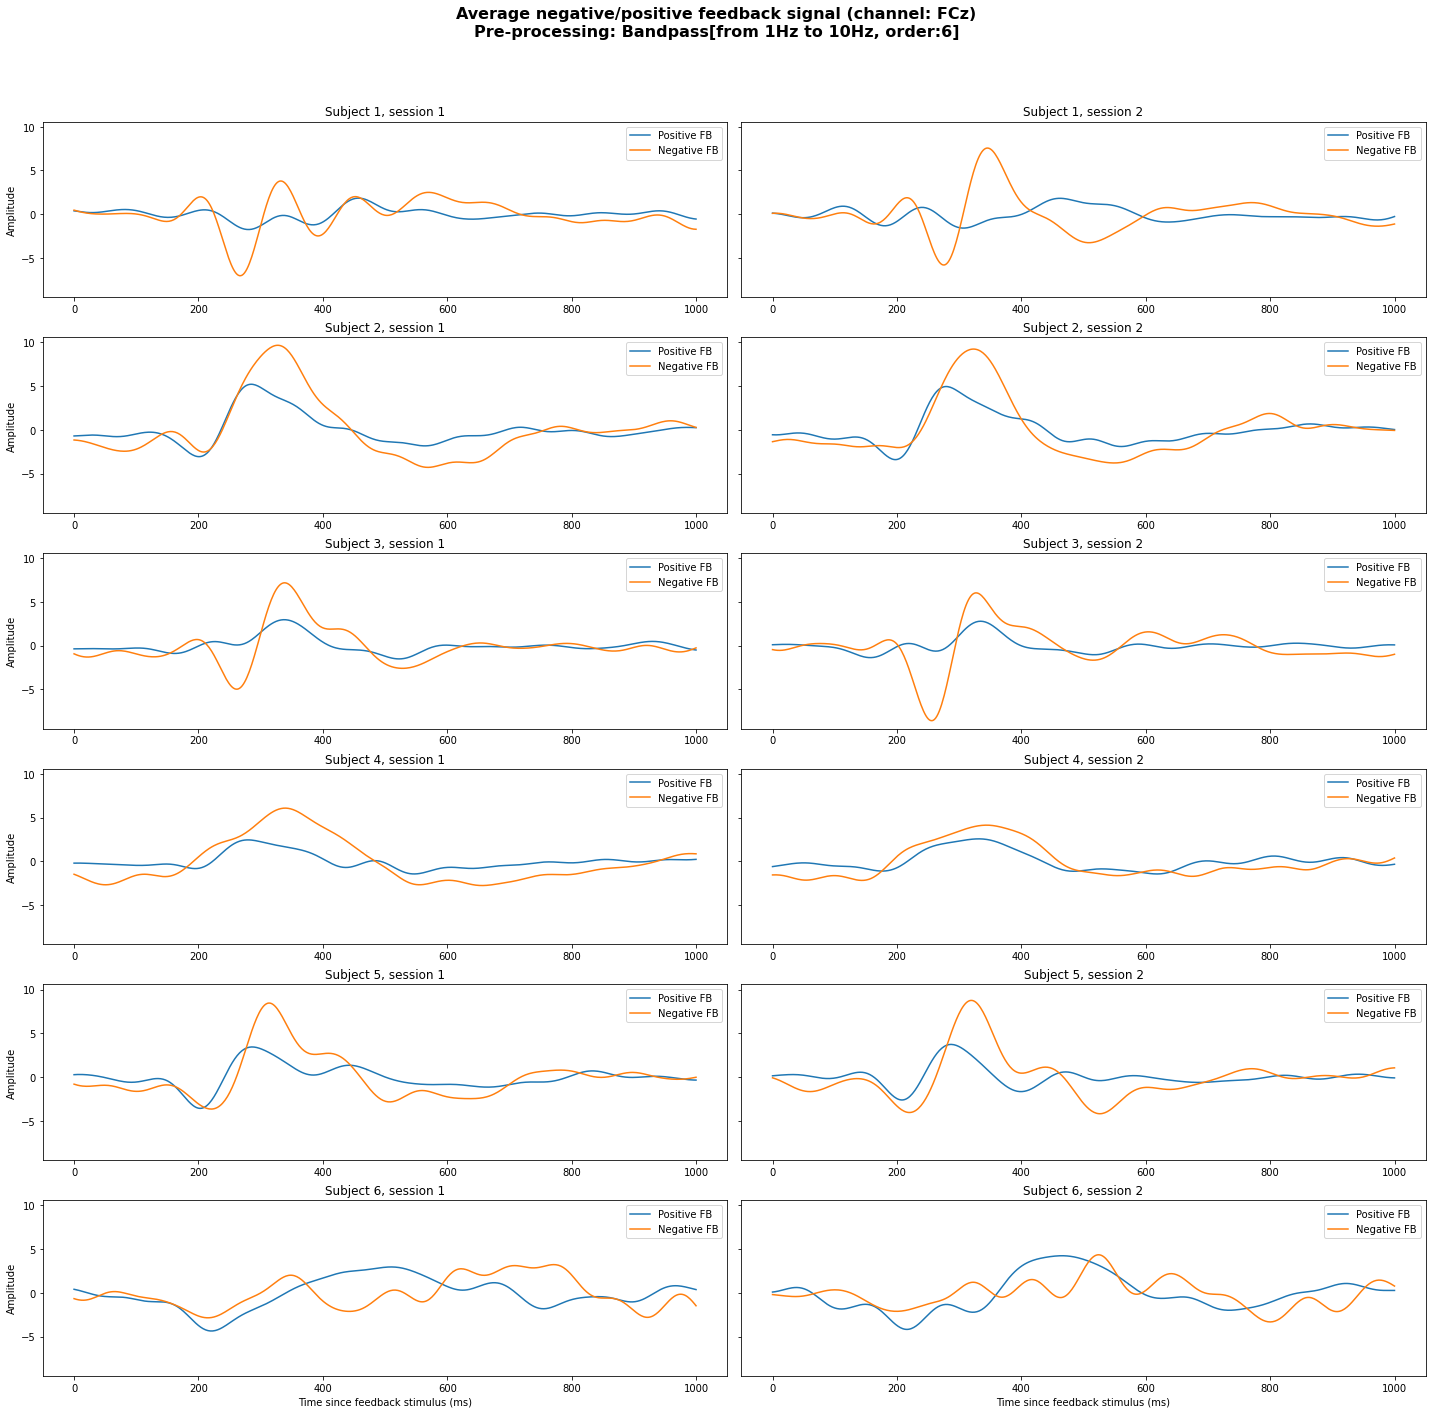

In [ ]:
# -------------------- Plot --------------------

# Subjects for which the plots will be displayed (to avoid too many graphs)
see_subjs = [1,2,3,4,5,6]

# Two overlayed plots per subject and session (positive and negative feedback)
fig, axes = plt.subplots(len(see_subjs), len(sessions_idx), figsize=(20,20),sharex=False, sharey=True)

# Get epoching data
fb_windowOnset = epoched_metadata['fb_windowOnset']
fb_windowSize = epoched_metadata['fb_windowSize']
fb_windowSizeSamples = epoched_metadata['fb_windowSizeSamples']

# Time array
t = np.linspace(fb_windowOnset, fb_windowOnset+fb_windowSize, num=fb_windowSizeSamples)
for subj_idx, subj in enumerate(see_subjs):
  for sess_idx, sess in enumerate(sessions_idx):
    axes[subj_idx,sess_idx].plot(t, trials[subj_idx, sess_idx, 1], label="Positive FB")
    axes[subj_idx,sess_idx].plot(t, trials[subj_idx, sess_idx, 0], label="Negative FB")
    axes[subj_idx,sess_idx].legend(loc='best')
    axes[subj_idx,sess_idx].set_title("Subject {}, session {}".format(subj, sess))

plt.setp(axes[-1,:], xlabel="Time since feedback stimulus (ms)")
plt.setp(axes[:,0], ylabel="Amplitude")
fig.suptitle('Average negative/positive feedback signal (channel: {})\nPre-processing: {}'.format(channel_name, processing_metadata2str(filtered_metadata)), fontsize=16, weight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.show()

##### Save plot

In [ ]:
save_path = project_root_folder + "Images/Pre-processing/"
img_name = file_name
fig.savefig(save_path + img_name + ".png", bbox_inches='tight')

#### Individual trials

##### Get trials

In [ ]:
see_subjs = [1,2,3,4]
session = 1
trials_session = np.random.choice(np.arange(1,61), 5)
trials = []

# Check which channels are available
all_channel_names = phisio_channel_names.copy()
if('channel_selection' in filtered_metadata):
  cs = filtered_metadata['channel_selection']
  if(cs['include_channels']):
    all_channel_names = [ch for ch in cs['include_channels']]
  elif(cs['exclude_channels']):
    all_channel_names = [ch for ch in all_channel_names if ch not in cs['exclude_channels']]

all_channel_indexes = np.arange(0, len(all_channel_names))
all_channels_name2idx = dict(zip(all_channel_names, all_channel_indexes))

# Select channel
channel_name = 'Cz'
ch = all_channels_name2idx.get(channel_name)

for idx,subject in enumerate(see_subjs):
  trials.append([])
  sub_sess_idx = np.where((epoched_data_labels[:,0]==subject) & (epoched_data_labels[:,1]==session))[0]
  trials[idx].append(epoched_data[sub_sess_idx[trials_session],ch,:])

trials = np.array(trials)

NameError: ignored

##### Plot

In [ ]:
# -------------------- Plot --------------------
# Two plots per subject (positive and negative feedback)
fig, axes = plt.subplots(nrows=len(see_subjs), ncols=5, figsize=(20,10),sharex=True, sharey=False)

# Get epoching data
fb_windowOnset = epoched_metadata['fb_windowOnset']
fb_windowSize = epoched_metadata['fb_windowSize']
fb_windowSizeSamples = epoched_metadata['fb_windowSizeSamples']

# Time array
t = np.linspace(fb_windowOnset, fb_windowOnset+fb_windowSize, num=fb_windowSizeSamples)
mask_session = data_labels[:,1]==session
for subj_idx, subj in enumerate(see_subjs):
  mask_subj = data_labels[:,0]==subj
  for trial_idx, trial in enumerate(trials_session):
    mask_trial = data_labels[:,2]==trial
    label_trial = data_labels[np.where(mask_subj & mask_session & mask_trial)[0],3][0]
    if(label_trial == 0):
      label_trial = "Negative FB"
      color = 'orangered'
    else:
      label_trial = "Positive FB"
      color = 'blue'
    axes[subj_idx,trial_idx].plot(t, trials[subj_idx, 0, trial_idx], label=label_trial, color=color)
    axes[subj_idx,trial_idx].legend(loc='best')
    axes[subj_idx,trial_idx].set_title("Subject {}, session {}, trial {}".format(subj, session, trial))

plt.setp(axes[-1,:], xlabel="Time since feedback stimulus (ms)")
plt.setp(axes[:,0], ylabel="Amplitude")
fig.suptitle('Average negative/positive feedback signal (channel: {})\nPre-processing: {}'.format(channel_name, processing_metadata2str(filtered_metadata)), fontsize=16, weight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.show()

##### Save plot

In [ ]:
save_path = project_root_folder + "Images/Pre-processing/"
img_name = file_name
fig.savefig(save_path + img_name + ".png", bbox_inches='tight')

#### ErrP and No ErrP with all trials in background

In [ ]:
# Append the bad and good feedbacks
trials = {0:{},1:{}}

# Define session (#1, #2 or 0 for both)
session = 1

# Check which channels are available
all_channel_names = phisio_channel_names.copy()
if('channel_selection' in filtered_metadata):
  cs = filtered_metadata['channel_selection']
  if(cs['include_channels']):
    all_channel_names = [ch for ch in cs['include_channels']]
  elif(cs['exclude_channels']):
    all_channel_names = [ch for ch in all_channel_names if ch not in cs['exclude_channels']]

all_channel_indexes = np.arange(0, len(all_channel_names))
all_channels_name2idx = dict(zip(all_channel_names, all_channel_indexes))

# Select channel
channel_name = 'FCz'
ch = all_channels_name2idx.get(channel_name)

# Masks for positive and negative feedbacks (to be applied to the labels array)
pos_fb_mask = data_labels[:,4] == 1
neg_fb_mask = np.invert(pos_fb_mask)
# For each subject
for subj_idx, subj in enumerate(subjects_idx):
  # Mask for current subject
  subj_mask = data_labels[:,0] == subj
  
  if(session == 0):
    sess_mask = (data_labels[:,1] == 1) | (data_labels[:,1] == 2)
  else:
    sess_mask = (data_labels[:,1] == session)

  # Get indexes
  pos_indexes = np.where(subj_mask & sess_mask & pos_fb_mask)[0]
  neg_indexes = np.where(subj_mask & sess_mask & neg_fb_mask)[0]

  trials[0][subj] = data[neg_indexes,ch,:] # Add negative at index 0
  trials[1][subj] = data[pos_indexes,ch,:] # Add positive at index 1


##### Plot

In [ ]:
# -------------------- Plot --------------------
# Two plots per subject (positive and negative feedback)
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(20,30),sharex=False, sharey=False)

# Get epoching data
fb_windowOnset = epoched_metadata['fb_windowOnset']
fb_windowSize = epoched_metadata['fb_windowSize']
fb_windowSizeSamples = epoched_metadata['fb_windowSizeSamples']

# Time array
t = np.linspace(fb_windowOnset, fb_windowOnset+fb_windowSize, num=fb_windowSizeSamples)

# For each subject
for subj_idx, subj in enumerate(subjects):
  # For both types of feedback (ErrP and no ErrP)
  for feedback_type in range(0,2):
    # Get feedback name
    feedback_name = ""
    if(feedback_type == 0):
      feedback_name = "ErrP"
    else:
      feedback_name = "No ErrP"

    # Print each trial in background
    for trial in trials[feedback_type][subj_idx+1]:
      axes[subj_idx,feedback_type].plot(t, trial, color='black',linestyle=":",linewidth=0.3)
    
    axes[subj_idx,feedback_type].plot(t, np.mean(trials[feedback_type][subj_idx+1],axis=0), color='red',linewidth=5)
    if(session == 0):
      axes[subj_idx,feedback_type].set_title("{} for subject {}, both sessions, {} trials".format(feedback_name, subj,trials[feedback_type][subj_idx+1].shape[0]),fontsize=20)
    else:
      axes[subj_idx,feedback_type].set_title("{} for subject {}, session {}, {} trials".format(feedback_name, subj, session,trials[feedback_type][subj_idx+1].shape[0]),fontsize=20)

plt.setp(axes[-1,:], xlabel="Time since feedback stimulus (ms)")
plt.setp(axes[:,0], ylabel="Amplitude")
fig.suptitle('ErrP and No ErrP with all trials in background (channel: {})\nPre-processing: {}'.format(channel_name, processing_metadata2str(filtered_metadata)), fontsize=20, weight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

## 3\. Deep Learning Model

Use [Comet](https://www.comet.ml/) to *visualize, compare and share all experimental data*.

Use [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/) to *decouple the science code from the engineering code*.

Both can be easily [combined](https://www.comet.ml/site/new-integration-comet-pytorch-lightning/).


---
Guide to use the code in this section:
1. Generate a **Comet experiment**
  * Associate a Comet API key to the current project and name the current experiment (optional)
    * The Comet Api Key can be easily accessed after signing up to [Comet](https://www.comet.ml/site/) with Github or mail address. Project and Workspace are optional but help organize which experiments belong to which modeling projects.
  * The API key (together with the project name and workspace name) are loaded from a file present in the root directory of the Drive. If none is present run the code which is commented in the previous cell after editing the necessary fields
  * A link to the Live Comet experiment will be provided after cell run
  * While executing *trainer.fit(model_name)* in the **Train** section, head to the Comet UI in the browser to visualize the training: metrics, parameters, code, system metrics, and more, all in real time.
2. Define **hyperparameters**
  * Besides the basic hyperparameters, more can be addded.
  * These are passed to the Comet Logger.
3. Download **dataset**
  * After running cell, choose the appropriate file and the dataset will be uploaded.
4. Define **Model**
  * The model architecture is defined in the class at the **Define Model** section.
  * It uses the **LightningModule** from [PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning) to abstract and separate the Research/Science component from the Engineering component.
  * Layers (convolution, max pooling, drop-outs, ...) are defined under the Model class constructer (*\_\_init\_\_*) and its feeding pipeline is defined in the *forward* function.
  * Download and split dataset
  * DataLoaders...
  * Oprimizer and Scheduler
  *

5. Terminate Experience
  * In a Jupyter or Colab notebook, Experiences are ended by running *comet_logger.experiment.end()*.

### Generate Comet experiment

Create a new Comet configuration file where the API key, project name and workspace name are stored.
Uncommnet, edit and run if no such file exists in the directory.

Check these values after logging-in in Comet.

In [ ]:
# # Create a comet configuration file to store private data and prevent from exposing it in this notebook.

# # Generate needed variables
# config_vars = {}
# config_vars['api_key'] = '...'
# config_vars['project_name'] = '...'
# config_vars['workspace'] = '...'

# # Store 'config_vars' as Pickle file in the root directory:
# save_file_pickle(config_vars, project_root_folder + "comet_ml_config.p")

Load configuration variables and create the Comet logger


In [ ]:
# Load configuration variables from previouslt stored configuration file.
# If no configuration file exists, create one with the previous code cell.
config_vars = open_file_pickle(project_root_folder + "comet_ml_config.p")

# Create a Comet experiment
api_key = config_vars['api_key']
project_name = config_vars['project_name']
workspace = config_vars['workspace']
# Name accoriding to model
experiment_name = 'CNN-Luo2'
experiment_creation_time = datetime.datetime.now().strftime("[%Y-%m-%d,%H:%M]")

comet_logger = pl.loggers.CometLogger(
  api_key = api_key,
  project_name = project_name,
  workspace = workspace,
  experiment_name = experiment_name,
  save_dir='logs/'
)

# print("Experiment is live on comet.ml: {}".format(comet_logger.experiment.url))

CometLogger will be initialized in online mode
COMET INFO: old comet version (3.1.12) detected. current: 3.2.2 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/leafarcoder/bci-feedback-classifier/248c0f5469b24d31913652c5a4ed3640



### Define datasets

Get datasets and divide into train and test sets
Run cell and using the prompt choose the appropriate data.

In [ ]:
# ++++++++++++++++++++++++ Load data ++++++++++++++++++++++++
# Show available files
# Show all files that were stored as Pickle files (Python library to serialize variables)
file_index = -1
available_files, available_files_types = [], []
# Only add Epoched data
get_available_pickle_folders(project_epoched_folder, "Epoching", available_files, available_files_types)
get_available_pickle_folders(project_balanced_folder, "Balanced", available_files, available_files_types)

while((file_index < 0) | (file_index > len(available_files)-1)):
  # Present choices
  print("     Index\tFolder type\tFolder/file name:")
  print(''.join(available_files_types))

  # Ask user which file to load:
  file_index = int(input("Data to load (choose an index from 0 to {}):\n".format(len(available_files)-1)))
  clear_output(wait=True)

file_path = available_files[file_index]
if(available_files_types[file_index].split("\t")[2] == "Epoched"):
  processing_type = "Epoched"
  # Get file
  (data, data_labels, filtered_metadata, epoched_metadata)= open_file_pickle(file_path)
elif(available_files_types[file_index].split("\t")[2] == "Balanced"):
  processing_type = "Balanced"
  # Get file
  (data, data_labels, filtered_metadata, epoched_metadata, balanced_metadata) = open_file_pickle(file_path)

# **********************************************************************************
# **************** Separate dataset into training and testing sets *****************
# **********************************************************************************

# Available methods (choose method in the prompt after running this cell):
#  - Method 1: Separate train and test datasets by sessions (sessions 1 or 2) with all subjects
#  - Method 2: Separate train and test datasets by sessions (sessions 1 or 2) for only one subject
#  - Method 3: Generate datasets from both sessions (random pick)
#  - Method 4: Choose any other subset (define programmatically)

available_methods = [
  "Separate train and test datasets by sessions (sessions 1 or 2) with all subjects",
  "Separate train and test datasets by sessions (sessions 1 or 2) for only one subject",
  "Generate datasets from both sessions (random pick)",
  "Choose any other subset (define programmatically)"
]

method_index = -1
# Prompt choice of method
while((method_index < 1) | (method_index > len(available_methods))):
  # Present choices
  print("Choose how to divide the whole dataset into training, validation and test datasets:\n")
  print("\t Index\tMethod description")
  print('\n'.join(["\t>{}\t{}".format(idx+1,x) for idx,x in enumerate(available_methods)]))
  
  # Ask user which method to use:
  method_index = int(input("\nMethod to use (choose an index from 1 to {}):\n".format(len(available_methods))))
  clear_output(wait=True)

if(method_index == 1):
  # ******************************* Method 1 *******************************
  # Separate train and test datasets by sessions (sessions 1 or 2) with all subjects 
  # *************************************************************************
  val_with_trainSession = False

  # Use the same session for both train and validation
  if(val_with_trainSession):
    # One of the sessions will be used for training.
    # Specify the train and validation relative sizes for that session (sum up to 1)
    train_perc = 0.8
    val_perc = 0.2

    # Define train and test sessions
    train_session = 1
    test_session = 2

    train_idxs = np.where(data_labels[:,1] == train_session)[0]
    test_idxs = np.where(data_labels[:,1] == test_session)[0]

    # Separate train dataset into train and validation
    train_size = len(train_idxs)
    train_norm_size = int(train_size * train_perc)
    val_norm_size = train_size - train_norm_size
    train_idxs, val_idxs = random_split(train_idxs, [train_norm_size, val_norm_size])
    train_size = len(train_idxs)
    test_size = len(test_idxs)
    val_size = len(val_idxs)

  # else use the same session for both test and validation
  elif(not val_with_trainSession):
    # One of the sessions will be used for training alone
    # Specify the test and validation relative sizes for that session (sum up to 1)
    test_perc = 0.5
    val_perc = 0.5

    # Define train and test sessions
    train_session = 1
    test_session = 2

    train_idxs = np.where(data_labels[:,1] == train_session)[0]
    test_idxs = np.where(data_labels[:,1] == test_session)[0]

    # Separate train dataset into train and validation
    test_size = len(test_idxs)
    test_norm_size = int(test_size * test_perc)
    val_norm_size = test_size - test_norm_size
    test_idxs, val_idxs = random_split(test_idxs, [test_norm_size, val_norm_size])
    train_size = len(train_idxs)
    test_size = len(test_idxs)
    val_size = len(val_idxs)

  # Redefine train, validation and test sizes (given both session sizes)
  test_perc = test_size/(test_size + train_size + val_size)
  train_perc = train_size/(test_size + train_size + val_size)
  val_perc = val_size/(test_size + train_size + val_size)

elif(method_index == 2):
  # ******************************* Method 2 *******************************
  # Separate train and test datasets by sessions (sessions 1 or 2) for only one subject
  #*************************************************************************

  # Choose subject
  subject = -1
  while((subject < 1) | (subject > 6)):
    # Ask user which method to use:
    subject = int(input("Choose a subject index from 1 to 6):\n"))
    clear_output(wait=True)

  # One of the sessions will be used for training.
  # Specify the train and validation relative sizes for that session (sum up to 1)
  train_perc = 0.8
  val_perc = 0.2

  # Define train and test sessions
  train_session = 1
  test_session = 2

  train_idxs = np.where((data_labels[:,1] == train_session) & (data_labels[:,0] == subject))[0]
  test_idxs = np.where((data_labels[:,1] == test_session) & (data_labels[:,0] == subject))[0]

  # Separate train dataset into train and validation
  train_size = len(train_idxs)
  train_norm_size = int(train_size * train_perc)
  val_norm_size = train_size - train_norm_size
  train_idxs, val_idxs = random_split(train_idxs, [train_norm_size, val_norm_size])
  train_size = len(train_idxs)
  test_size = len(test_idxs)
  val_size = len(val_idxs)

  # Redefine train, validation and test sizes (given both session sizes)
  test_perc = test_size/(test_size + train_size + val_size)
  train_perc = train_size/(test_size + train_size + val_size)
  val_perc = val_size/(test_size + train_size + val_size)

elif(method_index == 3):
  # ******************************* Method 3 *******************************
  # Generate datasets from both sessions (random pick)
  #*************************************************************************
  # Define test, train and validations set sizes (as percentages)
  train_perc = 0.7
  val_perc = 0.1
  test_perc = 0.2

  # Set sizes
  data_size = data.shape[0]
  train_size = int(data_size * train_perc)
  val_size = int(data_size * val_perc)
  test_size =  data_size - (train_size + val_size)

  # Define random indexes according to set sizes defined above for test, validation and train
  indeces = np.arange(data_size)
  random.shuffle(indeces)
  train_idxs = indeces[:train_size]
  val_idxs = indeces[train_size:(train_size+val_size)]
  test_idxs = indeces[(train_size+val_size):]

elif(method_index == 4):
  # ******************************* Method 4 *******************************
  # Choose any other subset (define programmatically)
  #*************************************************************************
  
  # Define test, train and validations set sizes (as percentages)
  train_perc = 0.7
  val_perc = 0.1
  test_perc = 0.2

  # Choose subject (1 to 6; -1 for all)
  subject = 6
  # Choose session (1 to 2; -1 for all)
  session = -1
  # Choose run (1 to 10; -1 for all)
  run = -1

  subj_mask = (data_labels[:,0]==subject) if(subject != -1) else np.ones(data.shape[0],dtype=bool)
  sess_mask = (data_labels[:,1]==session) if(session != -1) else np.ones(data.shape[0],dtype=bool)
  run_mask = (data_labels[:,2]==run) if(run != -1) else np.ones(data.shape[0],dtype=bool)

  labels_idxs = np.where(subj_mask & sess_mask & run_mask)[0]

  # Set sizes
  data_size = len(labels_idxs)
  train_size = int(data_size * train_perc)
  val_size = int(data_size * val_perc)
  test_size =  data_size - (train_size + val_size)

  # Define random indexes according to set sizes defined above for test, validation and train
  random.shuffle(labels_idxs)
  train_idxs = labels_idxs[:train_size]
  val_idxs = labels_idxs[train_size:(train_size+val_size)]
  test_idxs = labels_idxs[(train_size+val_size):]

# ************************************************************************
# *************************** Apply choice *******************************
#*************************************************************************
train_set = []
for train_idx in train_idxs:
  train_set.append([data[train_idx], data_labels[train_idx]])
val_set = []
for val_idx in val_idxs:
  val_set.append([data[val_idx], data_labels[val_idx]])
test_set = [] 
for test_idx in test_idxs:
  test_set.append([data[test_idx], data_labels[test_idx]])

# **********************************************************************************
# ***************************** Summarize choices **********************************
# **********************************************************************************
print("Dataset used:\n\t{}\n".format(os.path.basename(available_files[file_index])))
print("Dataset split method:\n\t{}".format(available_methods[method_index-1]))
if(method_index == 4):
  subj_txt = subject if(subject!=-1) else "All"
  sess_txt = session if(session!=-1) else "All"
  run_txt = run if(run!=-1) else "All"
  print("\t\tSubject(s): {}\n\t\tSession(s): {}\n\t\tRun(s): {}".format(subj_txt, sess_txt, run_txt))

Dataset used:
	bp[low:1,high:10,ord:6]_epoch[onset:0,size:600]_bal[added_to:0,#:3055].p

Dataset split method:
	Separate train and test datasets by sessions (sessions 1 or 2) with all subjects


### Define model

Models are defined by Python classes and any particular model is created when a class is instantiated.

In this project multiple models are tested. To keep track (a history record) of all studied models these are stored as separate classes, present in the *Model Classes* folder.

To define one particular model just run the cell below, choose one model from the prompt.
* The class will be imported as *model_class*
* The code from said class will be logged to the current Comet experiment (accessible in the Code tab)

In [4]:
# Add Model Classes path to the system path so the Classes can be imported
if not project_model_classes_folder in sys.path:
  sys.path.append(project_model_classes_folder)
# Add Models path to the system path so the PrintCallbacks can be imported
if not project_models_folder in sys.path:
  sys.path.append(project_models_folder)

# Get list of available classes
classes_list = [file_name for file_name in os.listdir(project_model_classes_folder) if file_name.endswith('.py')]

# Let user choose the model class to use
print("Index:\tModel class:")
for idx, class_name in enumerate(classes_list):
  print("> {}\t{}".format(idx, class_name))
index = int(input("\nModel class to use (choose an index from 0 to {}):\n".format(len(classes_list)-1)))
chosen_class = classes_list[index]

# Get class name (remove '.py' extension)
class_name = os.path.splitext(chosen_class)[0]
# Import class as 'model_class'
model_class = importlib.import_module(class_name)

# Import class that prints callbacks
printCallbacks = importlib.import_module("PrintCallbacks")

print("Done loading model \"{}\"!".format(class_name))

Index:	Model class:
> 0	ConvArch2_Dropout.py
> 1	Model1.py
> 2	ConvArch2_BN.py
> 3	ConvNet.py
> 4	ConvArch1_Adam.py
> 5	ConvArch2.py
> 6	CNN-R.py
> 7	CCNN.py
> 8	ConvArch1.py
> 9	Experiments.py
> 10	CNN-Luo.py
> 11	CNN-Luo2.py
> 12	BN3.py
> 13	OCLNN.py
> 14	own2.py
> 15	own1.py
> 16	own3.py
> 17	own4.py

Model class to use (choose an index from 0 to 17):
17
Done loading model "own4"!


#### Test nets


In [ ]:
test_trial = [train_set[0][0], train_set[1][0], train_set[2][0]]
test_trial = torch.tensor(test_trial)
print("Input size: {}".format(test_trial.shape))

test_label = [train_set[0][1][4], train_set[1][1][4], train_set[2][1][4]]
test_label = torch.tensor(test_label)

loss = nn.CrossEntropyLoss()

# Define layers

conv1 = nn.Conv1d(2,16,64)
layer2 = nn.Sequential(
    nn.Conv1d(16,32,64),
    nn.ReLU(),
    nn.MaxPool1d(2)
)
layer3 = nn.Sequential(
    nn.Conv1d(32,32,32),
    nn.ReLU(),
    nn.MaxPool1d(2)
)
layer4 = nn.Sequential(
    nn.Conv1d(32,64,16),
    nn.ReLU(),
    nn.MaxPool1d(2)
)
layer5 = nn.Sequential(
    # Flattens
    nn.Flatten(),
    # Fully Connected layer
    nn.Linear(64*33,2),
    # To apply Cross Entropy Loss don't apply Softmax (it's included there)
)

# Forward propagation
out1 = conv1(test_trial.float())
out2 = layer2(out1)
out3 = layer3(out2)
out4 = layer4(out3)
out5 = layer5(out4)

out_soft = F.softmax(out5,dim=-1)
print(out_soft)
#print("{} --> {} --> {} --> {} --> {}".format(out1.shape,out2.shape,out3.shape,out4.shape,out5.shape))

# Compute loss
out_loss = loss(out5, test_label)
print(out_loss)
out_loss2 = nn.functional.cross_entropy(out5, test_label)
print(out_loss2)

Input size: torch.Size([3, 2, 512])
tensor([[0.5410, 0.4590],
        [0.5067, 0.4933],
        [0.5188, 0.4812]], grad_fn=<SoftmaxBackward>)
tensor(0.7390, grad_fn=<NllLossBackward>)
tensor(0.7390, grad_fn=<NllLossBackward>)


In [ ]:
train_session = 1
test_session = 2

train_idxs = np.where(data_labels[:,1] == train_session)[0]
train_norm_size = int(len(train_idxs) * train_perc/(train_perc + val_perc))
val_norm_size = len(train_idxs) - train_norm_size
train_idxs, val_idxs = random_split(train_idxs, [train_norm_size, val_norm_size])
test_idxs = np.where(data_labels[:,1] == test_session)[0]


In [ ]:
print(len(train_idxs))
print(len(val_idxs))
print(len(test_idxs))

3464
495
4211


### Instantiate model


1.   Define unique identifiers for current experience
2.   Instantiate model
3.   Add all necessary logs to the Comet model

In [ ]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++ Define unique identifiers ++++++++++++++++++++++++++
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Use to overwrite hyperparamters defined in the model
hyper_params = {
#     'input_size': test_set[0][0].shape,
#     'num_classes': 2,
     'batch_size': 64,               # Batch size (try powers of 2)
#     'test_batch_size': 1,
#     'max_num_epochs': 500,
#     'optimizer': 'SGD',              # SGD, Adam, ...
#     'learning_rate': 0.001,          # Learning rate for Optimizer
#     'momentum': 0.9,                 # Momentum for Optimizer
#     'weight_decay': 0.00001,          # Weight decay (L2 regularization) 
#     'dropout_rate_fc': 0.2,          # Dropout rate at Fully Connected layers
#     'dropout_rate_conv': 0.2,
   }
                                
dataset_information = {
    'percent_train_dataset': train_perc,
    'percent_test_dataset': test_perc,
    'percent_val_dataset': val_perc,
    'dataset_split_method_descr': available_methods[method_index-1],
    'dataset_split_method_idx': method_index
  }

experience_unique_identifiers = {
    'original_work': "CNN-Luo2",         # Modifications applied to original work
    'mod_id': '',                  # Name/ID of the modification ('replicate' is an attempt to replicate the original work)
    'research_question_id': 'CNN-Luo2',
    'modified_vars': '-',      # Modified variables (compared to original work)
    #'modified_vars_values': "subj:{}; sess:{}; run:{}; train:{}; test:{}".format(subj_txt,sess_txt,run_txt,"random","random"),         # Collection of values corresponding to the modified variables
    'modified_vars_values': '-',         # Collection of values corresponding to the modified variables
    'mod_instance': 3                     # Number of experience repetition on the same mod_id
  }

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# +++++++++++++++++++++++++++ Instantiate model +++++++++++++++++++++++++++++
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Load/Reload classes
printCallbacks = importlib.reload(printCallbacks)
model_class = importlib.reload(model_class)

# Instantiate model
model = model_class.Net(input_size=test_set[0][0].shape, hyperparams=hyper_params)

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# +++++++++++++++++++++++++ Instantiate Data Loader +++++++++++++++++++++++++
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

class DataModule(pl.LightningDataModule):
  def __init__(self, train_set, val_set, test_set, batch_size):
      super().__init__()
      self.train_set = train_set
      self.val_set = val_set
      self.test_set = test_set
      self.batch_size = batch_size

  # def prepare_data(self):
  #   pass

  # def setup(self, stage=None):
  #   pass

  def train_dataloader(self):
      return DataLoader(self.train_set, batch_size=self.batch_size, num_workers=8, shuffle=True)

  def val_dataloader(self):
      return DataLoader(self.val_set, batch_size=self.batch_size, num_workers=8, shuffle=False)

  def test_dataloader(self):
      return DataLoader(self.test_set, batch_size=1, num_workers=8, shuffle=False)

# ---------------------------------------------------------------------------
# ----------------------- Add logs to Comet ML ------------------------------
# ---------------------------------------------------------------------------

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++ Add information to  Hyper Parameters tab +++++++++++++++++
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
comet_logger.experiment.log_parameters(model.get_hyperparams())

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++ Enable logging to Output tab +++++++++++++++++++++
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Enable log shown here to be logged into Comet (to Output tab)
comet_logger.auto_output_logging = "simple"

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++ Add information to Assets tab ++++++++++++++++++++
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Log datasets used to train and test model as Pickle files (to Assets tab)
train_file = outfile = open("train_file.p",'wb')
val_file = outfile = open("val_file.p",'wb')
test_file = outfile = open("test_file.p",'wb')
pk.dump(train_set, train_file)
pk.dump(val_set, val_file)
pk.dump(test_set, test_file)
# Train
comet_logger.experiment.log_asset(file_data="train_file.p", file_name="train_file.p",overwrite=True)
# Validation
comet_logger.experiment.log_asset(file_data="val_file.p", file_name="val_file.p",overwrite=True)
# Test
comet_logger.experiment.log_asset(file_data="test_file.p", file_name="test_file.p",overwrite=True)
# Close all files
train_file.close()
val_file.close()
test_file.close()

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# +++++++++++++++++ Add information to Systems Metrics tab ++++++++++++++++++
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Operative system
# Prevent output display (capture output)
# %%capture
operative_system = !uname -o
operative_system = operative_system[0]
# Python version
python_version = !python3 --version
python_version = python_version[0]
# Get RAM memory
mem_info = !cat /proc/meminfo
total_RAM_Kb = int(mem_info[0].split(":")[1].strip().split(" ")[0])
total_RAM_Gb = round(total_RAM_Kb/1000000,2)
# Get processor name and type
processor_type = ""
processor_name = ""
processor_bits = !uname -p
processor_bits = processor_bits[0]
device_name = tf.test.gpu_device_name()
if(device_name == '/cpu:0'):
  cpu_info = !cat /proc/cpuinfo
  processor_name = cpu_info[4].split(": ")[1]
  processor_type = "CPU"
elif(device_name == '/device:GPU:0'):
  gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv,noheader
  processor_name = gpu_name[0]
  processor_type = "GPU"
else:
  processor_type = "TPU"

comet_logger.experiment.log_system_info("operative_system",operative_system)
comet_logger.experiment.log_system_info("python_version",python_version)
comet_logger.experiment.log_system_info("total_RAM_Gb", total_RAM_Gb)
comet_logger.experiment.log_system_info("processor_bits",processor_bits)
comet_logger.experiment.log_system_info("processor_type", processor_type)
comet_logger.experiment.log_system_info("processor_name", processor_name)

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# +++++++++++++++++++++++ Add information to HTML tab +++++++++++++++++++++++
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Add model explanation to Comet (under HTML tab)
comet_logger.experiment.log_html(model_class.Net.explainModel())

# Add dataset sizes (to HTML tab)
train_size = len(train_set)
val_size = len(val_set)
test_size = len(test_set)
total_size = train_size + val_size + test_size
dataset_sizes_txt = "<h2>Dataset sizes</h2>"
dataset_sizes_txt += """<p>Train size: {} ({}%)<br>
                            Validation size: {} ({}%)<br>
                            Test size: {} ({}%)<br>
                            Total size: {}<br>
                            (Download the datasets used in the Assets tab)<br><br>
                            Method to split whole dataset into train, validation and test datasets:<br>
                            {}<br></p>""".format(train_size, round(train_perc*100,2), val_size, round(val_perc*100,2), test_size, round(test_perc*100,2), total_size,available_methods[method_index-1])
comet_logger.experiment.log_html(dataset_sizes_txt)

# Add data metadata: filtering, epoching, balancing (to HTML tab)
metadata_txt = "<h2>Pre-processing metadata</h2>"

if('bandpass_filter' in filtered_metadata):
  filt = filtered_metadata['bandpass_filter']
  metadata_txt += "<h4>Bandpass filtering</h4>"
  metadata_txt += """<p>{}th order filter from {}Hz to {} Hz ({} sampling freq.)</p>""".format(filt['order'],filt['low_freq'],filt['high_freq'],filt['fs'])

if('channel_selection' in filtered_metadata):
  channel_sel = filtered_metadata['channel_selection']
  metadata_txt += "<h4>Channel selection</h4>"
  metadata_txt += """<p>{} channels selected:<br>{}</p>""".format(channel_sel['num_channels'],  channel_sel['include_channels'])

metadata_txt += "<h2>Epoching metadata</h2>"
metadata_txt += """<p>Onset: {}ms<br>Duration: {}ms<br>Duration: {} samples</p>""".format(epoched_metadata['fb_windowOnset'], epoched_metadata['fb_windowSize'], epoched_metadata['fb_windowSizeSamples'])

metadata_txt += "<h2>Balancing metadata</h2>"
if(balanced_metadata['added_to_class'] == 0):
  metadata_txt += """<p>{} samples randomly replicated in class 0 (ErrP): {} times the original size.</p>""".format(balanced_metadata['clones_added'],round(balanced_metadata['replicate_fold'],2))
else:
  metadata_txt += """<p>{} samples randomly replicated in class 1 (No ErrP): {} times the original size.</p>""".format(balanced_metadata['clones_added'],round(balanced_metadata['replicate_fold'],2))

comet_logger.experiment.log_html(metadata_txt)

# Add System specs (to HTML tab)
sysyem_specs_txt = "<h2>System specifications</h2>"
sysyem_specs_txt += """<p>Operative System: {} ({})<br>
                          Python version:   {}<br>
                          Total RAM:        {} Gb<br>
                          Processor type:   {}<br>
                          Processor name:   {}<br></p>""".format(operative_system, processor_bits, python_version, total_RAM_Gb, processor_type, processor_name)
comet_logger.experiment.log_html(sysyem_specs_txt)

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++ Add information to Other tab +++++++++++++++++++++++
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
comet_logger.experiment.log_others(experience_unique_identifiers)
comet_logger.experiment.log_others(dataset_information)

### Train model

#### Search best Learning Rate

Best learning rate is: 0.0033884415613920278


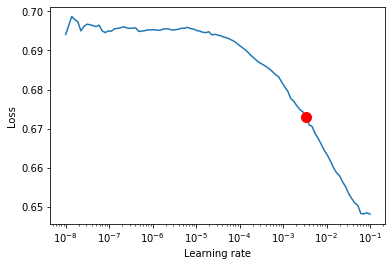

In [ ]:
trainer = pl.Trainer(show_progress_bar=False)
lr_finder = trainer.lr_find(model,max_lr=0.1)
fig = lr_finder.plot(suggest=True)
fig.show()
print("Best learning rate is: {}".format(lr_finder.suggestion()))

#### Train Model

In [ ]:
# ++++++++++++++++++++++++++++++++ Upload data ++++++++++++++++++++++++++++++++
dm = DataModule(train_set, val_set, test_set, hyper_params['batch_size'])

# Create Early Stop callback
early_stop_callback = pl.callbacks.EarlyStopping(
   monitor='val_loss',
   patience=50,
)

# ++++++++++++++++ Create Trainer (with reference to the logger created previously) ++++++++++++++++

# Using CPU
# trainer = pl.Trainer(
#     logger=comet_logger, 
#     callbacks=[printCallbacks.PrintCallbacks()]
#     )

# Using GPU
trainer = pl.Trainer(
    # show_progress_bar=False,  # Dont show progress bars
    max_epochs=500,
    gpus=-1,
    logger=comet_logger,
    callbacks=[printCallbacks.PrintCallbacks()],
    early_stop_callback=early_stop_callback,
    fast_dev_run=False      # Set to True to run one train, val and test epoch to test model
    );

# Using TPU
# trainer = pl.Trainer(
#     max_epochs=15,
#     num_tpu_cores=8,
#     logger=comet_logger, 
#     callbacks=[printCallbacks.PrintCallbacks()]
#     )

# To measure training time
start_time = time.time()

# Train model
trainer.fit(model, datamodule=dm);

# Log training time (to Metric tab and HTML tab)
training_time = round(time.time() - start_time,1)
comet_logger.experiment.log_metric("training_time_sec", training_time)
train_time_txt = "<h2>Training duration</h2>"
train_time_txt += "<p>{} seconds (~{} minutes)</p><br>".format(training_time, round(training_time/60))
comet_logger.experiment.log_html(train_time_txt)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | layer1        | Sequential       | 2 K   
1 | layer2        | Sequential       | 40 K  
2 | layer3        | Sequential       | 0     
3 | flatten       | Flatten          | 0     
4 | layer4        | Sequential       | 1 K   
5 | loss_function | CrossEntropyLoss | 0     


Starting to init trainer!


Training started...


Saving latest checkpoint..
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/leafarcoder/bci-feedback-classifier/248c0f5469b24d31913652c5a4ed3640
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     acc_train [60]  : (72.0, 97.0)
COMET INFO:     acc_val [59]    : (68.1515121459961, 80.03030395507812)
COMET INFO:     epoch [119]     : (0, 58)
COMET INFO:     loss [366]      : (0.07497242093086243, 0.731421947479248)
COMET INFO:     loss_train [60] : (0.12040147185325623, 0.5885618925094604)
COMET INFO:     loss_val [59]   : (0.45482122898101807, 0.8107967972755432)
COMET INFO:   Others:
COMET INFO:     Name                       : CNN-Luo2
COMET INFO:     dataset_split_method_descr : Separate train and test datasets by sessions (sessions 1 or 2) with all subjects
COMET INFO:     dataset_split

COMET INFO: Uploading stats to Comet before program termination (may take several seconds)
COMET INFO: old comet version (3.1.12) detected. current: 3.2.2 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/leafarcoder/bci-feedback-classifier/248c0f5469b24d31913652c5a4ed3640



### Test model

(Evaluate accuracy)

In [ ]:
# ************************* Test the model *************************
trainer.test(datamodule=dm)

# ************************* Log Confusion Matrix to Comet ML *************************
# Get test y_true and y_predicton vectors (and convert to vectors)
(y_true, y_predicted) = model.get_test_labels_predictions()
# Convert from Tensor to list
y_true = y_true.reshape(-1).tolist()
y_predicted = y_predicted.reshape(-1).tolist()

# Convert list representation to matrix representation (as required by the log_confusion_matrix function)
# At the same time count True positives (TP), False positives (FP), True negatives (TN) and False negatives (FN)
y_true_matrix, y_predicted_matrix = [], []
TP, FP, TN, FN = 0, 0, 0, 0
for i in range(len(y_true)):
  y_true_add = [0,0]
  y_pred_add = [0,0]
  y_true_add[int(y_true[i])] = 1
  y_pred_add[int(y_predicted[i])] = 1
  y_true_matrix.append(y_true_add)
  y_predicted_matrix.append(y_pred_add)
  if(y_true[i] == 0):
    if(y_predicted[i] == 0):
      TP += 1
    else:
      FN += 1
  else:
    if(y_predicted[i] == 0):
      FP += 1
    else:
      TN += 1

# Log Confusion matrix
comet_logger.experiment.log_confusion_matrix(title="Confusion matrix",
                                             labels=["ErrP","No ErrP"],
                                             y_true=y_true_matrix,
                                             y_predicted=y_predicted_matrix)

# Log confusion matrix metrics
comet_logger.experiment.log_metric("true_positives", TP)
comet_logger.experiment.log_metric("true_negatives", TN)
comet_logger.experiment.log_metric("false_positives", FP)
comet_logger.experiment.log_metric("false_negatives", FN)
specificity = TN/(TN+FP)
sensitivity = TP/(TP+FN)
precision = TP/(TP+FP)
negative_predictive_value = TN/(TN+FN)
accuracy_conf_matrix = (TP+TN)/(FP+FN+TP+TN)
F1_score = (2*TP)/(2*TP+FP+FN)
MCC = ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
nMCC = (MCC+1)/2
comet_logger.experiment.log_metric("specificity", specificity)
comet_logger.experiment.log_metric("sensitivity", sensitivity)
comet_logger.experiment.log_metric("precision", precision)
comet_logger.experiment.log_metric("negative_predictive_value", negative_predictive_value)
comet_logger.experiment.log_metric("accuracy_conf_matrix", accuracy_conf_matrix)
comet_logger.experiment.log_metric("F1_score", F1_score)
comet_logger.experiment.log_metric("MCC", MCC)
comet_logger.experiment.log_metric("nMCC", nMCC)

# ************************* Log Code to Comet *************************
# Add code from class (.py) file to Comet Experiment (accessible in the Code tab)
class_path = project_model_classes_folder + chosen_class
comet_logger.experiment.set_code(filename=class_path, overwrite=True)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'acc_subj_1': tensor(81.7175),
 'acc_subj_2': tensor(86.1035),
 'acc_subj_3': tensor(81.6817),
 'acc_subj_4': tensor(69.5266),
 'acc_subj_5': tensor(70.8447),
 'acc_subj_6': tensor(72.1893),
 'acc_test': tensor(77.0913)}
--------------------------------------------------------------------------------



### Save model

In [ ]:
# Saves a serialized object to disk. This function uses Python’s pickle utility for serialization.
model_save_path = project_model_saves_folder + experiment_name + "_{}.pt".format(experiment_creation_time)
torch.save(model.state_dict(), model_save_path)

# Log the current model (provides downloadable link)
comet_logger.experiment.log_model(experiment_name, model_save_path)

# ************************************************************************
# ************************* Terminate experiment *************************
# ************************************************************************
comet_logger.experiment.end()

COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/leafarcoder/bci-feedback-classifier/248c0f5469b24d31913652c5a4ed3640
COMET INFO:   Metrics:
COMET INFO:     F1_score                  : 0.7476439790575916
COMET INFO:     MCC                       : 0.5446390358791728
COMET INFO:     acc_subj_1                : 81.71745300292969
COMET INFO:     acc_subj_2                : 86.1035385131836
COMET INFO:     acc_subj_3                : 81.68167877197266
COMET INFO:     acc_subj_4                : 69.52662658691406
COMET INFO:     acc_subj_5                : 70.84468841552734
COMET INFO:     acc_subj_6                : 72.18934631347656
COMET INFO:     acc_test                  : 77.09125518798828
COMET INFO:     accuracy_conf_matrix      : 0.7709125475285171
COMET INFO:     epo

### Upload model

Upload from Comet or stores Model in directory.

Remember to call *model.eval()* to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.

In [ ]:
# ++++++++++++++++++++++++ Choose experience ++++++++++++++++++++++++

# Show available files
# Show all files that were stored as Pytorch files ('pt')
model_index = -1
available_models = [x for x in os.listdir(project_model_saves_folder) if x.endswith('.pt')]

while((model_index < 0) | (model_index > len(available_models)-1)):
  # Present choices
  print("\tIndex\tModel name:")
  for idx, model_name in enumerate(available_models):
    print("\t{}\t{}".format(idx, model_name))

  # Ask user which model to load:
  model_index = int(input("\nModel to load (choose an index from 0 to {}):\n".format(len(available_models)-1)))
  clear_output(wait=True)

model_name = available_models[model_index]
model_load_path = project_model_saves_folder + model_name
# Instantiate a generic model (random weights)
model = model_class.Net(train_dataset=train_set, val_dataset=val_set, test_dataset=test_set)
# Update weights by loading stored model
model.load_state_dict(torch.load(model_load_path))
# Change to evaluate mode (not training)
model.eval();
print("Model {} loaded!".format(model_name))

	Index	Model name:
	0	Bellary_2019_[2020-05-28,18:41].pt
	1	Bellary_2019_[2020-05-29,14:38].pt
	2	ConvArch2_[2020-05-30,14:35].pt
	3	ConvArch2_[2020-05-30,14:43].pt
	4	ConvArch2_[2020-05-30,16:45].pt
	5	ConvArch2_[2020-05-30,17:38].pt
	6	ConvArch2_[2020-05-30,18:07].pt
	7	ConvArch2_[2020-05-30,18:50].pt
	8	ConvArch2_[2020-05-30,19:20].pt
	9	ConvArch2_[2020-05-30,20:05].pt
	10	ConvArch2_[2020-05-30,20:50].pt
	11	ConvArch2_[2020-05-30,21:38].pt
	12	ConvArch2_[2020-05-30,22:35].pt
	13	ConvArch2_[2020-06-01,18:08].pt
	14	ConvArch2_[2020-06-01,19:07].pt
	15	ConvArch2_[2020-06-01,19:22].pt
	16	ConvArch2_[2020-06-01,20:03].pt
	17	ConvArch2_[2020-06-01,20:37].pt
	18	ConvArch2_[2020-06-01,21:20].pt
	19	ConvArch2_[2020-06-01,21:29].pt
	20	ConvArch2_[2020-06-01,21:38].pt
	21	ConvArch2_[2020-06-01,21:48].pt
	22	ConvArch2_[2020-06-01,21:58].pt
	23	ConvArch2_[2020-06-01,22:12].pt
	24	ConvArch2_[2020-06-01,22:23].pt
	25	ConvArch2_[2020-06-01,22:34].pt
	26	ConvArch2_[2020-06-01,22:45].pt
	27	ConvArch2

#### Evaluate uploaded model

In [ ]:
# Define test dataloader
test_dataloader = DataLoader(test_set, batch_size=1, num_workers=8)

# Run model for each test sample
correct_samples = 0
total_samples = 0
subj_results = [[],[],[],[],[],[]]
for sample in test_dataloader:
  x, y_all = sample

  y = y_all[:,4].tolist()[0] # get only label
  y_logits = model(x)
  y_hat = torch.round(F.softmax(y_logits, dim=-1)).reshape(-1).tolist()

  # Specificy the subject from where this sample comes from:
  subj_results[y_all[:,0]-1].append(y_hat[y])

  total_samples += 1
  correct_samples += (y_hat[y])

accuracy = (correct_samples/total_samples)*100
# Individual subject accuracy
subj_acc = [0]*6
for subj in range(6):
  subj_acc[subj] = sum(subj_results[subj]) / len(subj_results[subj])

print("Overall accuracy:\t{}%\n".format(round(accuracy,2)))
for subj in range(6):
  print("Accuracy for subject {}:\t{}%".format(subj+1, round(subj_acc[subj]*100,2)))

Overall accuracy:	96.94%

Accuracy for subject 1:	98.08%
Accuracy for subject 2:	94.91%
Accuracy for subject 3:	96.27%
Accuracy for subject 4:	98.25%
Accuracy for subject 5:	97.25%
Accuracy for subject 6:	96.81%


# Run batch of experiences

In [4]:
research_question_id = "own_8"
model_index = 21

mod_inst_versions = [9,10]
for mod_inst_version in mod_inst_versions:

  clear_output(wait=True)

  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # Generate Comet experiment

  # Load configuration variables from previouslt stored configuration file.
  # If no configuration file exists, create one with the previous code cell.
  config_vars = open_file_pickle(project_root_folder + "comet_ml_config.p")

  # Create a Comet experiment
  api_key = config_vars['api_key']
  project_name = config_vars['project_name']
  workspace = config_vars['workspace']
  # Name accoriding to model
  experiment_name = 'own'
  experiment_creation_time = datetime.datetime.now().strftime("[%Y-%m-%d,%H:%M]")

  comet_logger = pl.loggers.CometLogger(
    api_key = api_key,
    project_name = project_name,
    workspace = workspace,
    experiment_name = experiment_name,
    save_dir='logs/'
  )

  # print("Experiment is live on comet.ml: {}".format(comet_logger.experiment.url))

  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # Define dataset

  
  # ++++++++++++++++++++++++ Load data ++++++++++++++++++++++++
  # Show available files
  # Show all files that were stored as Pickle files (Python library to serialize variables)
  file_index = 10
  available_files, available_files_types = [], []
  # Only add Epoched data
  get_available_pickle_folders(project_epoched_folder, "Epoching", available_files, available_files_types)
  get_available_pickle_folders(project_balanced_folder, "Balanced", available_files, available_files_types)

  # while((file_index < 0) | (file_index > len(available_files)-1)):
  #   # Present choices
  #   print("     Index\tFolder type\tFolder/file name:")
  #   print(''.join(available_files_types))

  #   # Ask user which file to load:
  #   file_index = int(input("Data to load (choose an index from 0 to {}):\n".format(len(available_files)-1)))
  #   clear_output(wait=True)

  file_path = available_files[file_index]
  if(available_files_types[file_index].split("\t")[2] == "Epoched"):
    processing_type = "Epoched"
    # Get file
    (data, data_labels, filtered_metadata, epoched_metadata)= open_file_pickle(file_path)
  elif(available_files_types[file_index].split("\t")[2] == "Balanced"):
    processing_type = "Balanced"
    # Get file
    (data, data_labels, filtered_metadata, epoched_metadata, balanced_metadata) = open_file_pickle(file_path)

  # **********************************************************************************
  # **************** Separate dataset into training and testing sets *****************
  # **********************************************************************************

  # Available methods (choose method in the prompt after running this cell):
  #  - Method 1: Separate train and test datasets by sessions (sessions 1 or 2) with all subjects
  #  - Method 2: Separate train and test datasets by sessions (sessions 1 or 2) for only one subject
  #  - Method 3: Generate datasets from both sessions (random pick)
  #  - Method 4: Choose any other subset (define programmatically)

  available_methods = [
    "Separate train and test datasets by sessions (sessions 1 or 2) with all subjects",
    "Separate train and test datasets by sessions (sessions 1 or 2) for only one subject",
    "Generate datasets from both sessions (random pick)",
    "Choose any other subset (define programmatically)"
  ]

  method_index = 1
  # Prompt choice of method
  # while((method_index < 1) | (method_index > len(available_methods))):
  #   # Present choices
  #   print("Choose how to divide the whole dataset into training, validation and test datasets:\n")
  #   print("\t Index\tMethod description")
  #   print('\n'.join(["\t>{}\t{}".format(idx+1,x) for idx,x in enumerate(available_methods)]))
    
  #   # Ask user which method to use:
  #   method_index = int(input("\nMethod to use (choose an index from 1 to {}):\n".format(len(available_methods))))
  #   clear_output(wait=True)

  if(method_index == 1):
    # ******************************* Method 1 *******************************
    # Separate train and test datasets by sessions (sessions 1 or 2) with all subjects 
    # *************************************************************************
    val_with_trainSession = True

    # Use the same session for both train and validation
    if(val_with_trainSession):
      # One of the sessions will be used for training.
      # Specify the train and validation relative sizes for that session (sum up to 1)
      train_perc = 0.8
      val_perc = 0.2

      # Define train and test sessions
      train_session = 1
      test_session = 2

      train_idxs = np.where(data_labels[:,1] == train_session)[0]
      test_idxs = np.where(data_labels[:,1] == test_session)[0]

      # Separate train dataset into train and validation
      train_size = len(train_idxs)
      train_norm_size = int(train_size * train_perc)
      val_norm_size = train_size - train_norm_size
      train_idxs, val_idxs = random_split(train_idxs, [train_norm_size, val_norm_size])
      train_size = len(train_idxs)
      test_size = len(test_idxs)
      val_size = len(val_idxs)

    # else use the same session for both test and validation
    elif(not val_with_trainSession):
      # One of the sessions will be used for training alone
      # Specify the test and validation relative sizes for that session (sum up to 1)
      test_perc = 0.5
      val_perc = 0.5

      # Define train and test sessions
      train_session = 1
      test_session = 2

      train_idxs = np.where(data_labels[:,1] == train_session)[0]
      test_idxs = np.where(data_labels[:,1] == test_session)[0]

      # Separate train dataset into train and validation
      test_size = len(test_idxs)
      test_norm_size = int(test_size * test_perc)
      val_norm_size = test_size - test_norm_size
      test_idxs, val_idxs = random_split(test_idxs, [test_norm_size, val_norm_size])
      train_size = len(train_idxs)
      test_size = len(test_idxs)
      val_size = len(val_idxs)

    # Redefine train, validation and test sizes (given both session sizes)
    test_perc = test_size/(test_size + train_size + val_size)
    train_perc = train_size/(test_size + train_size + val_size)
    val_perc = val_size/(test_size + train_size + val_size)

  elif(method_index == 2):
    # ******************************* Method 2 *******************************
    # Separate train and test datasets by sessions (sessions 1 or 2) for only one subject
    #*************************************************************************

    # Choose subject
    subject = -1
    while((subject < 1) | (subject > 6)):
      # Ask user which method to use:
      subject = int(input("Choose a subject index from 1 to 6):\n"))
      clear_output(wait=True)

    # One of the sessions will be used for training.
    # Specify the train and validation relative sizes for that session (sum up to 1)
    train_perc = 0.8
    val_perc = 0.2

    # Define train and test sessions
    train_session = 1
    test_session = 2

    train_idxs = np.where((data_labels[:,1] == train_session) & (data_labels[:,0] == subject))[0]
    test_idxs = np.where((data_labels[:,1] == test_session) & (data_labels[:,0] == subject))[0]

    # Separate train dataset into train and validation
    train_size = len(train_idxs)
    train_norm_size = int(train_size * train_perc)
    val_norm_size = train_size - train_norm_size
    train_idxs, val_idxs = random_split(train_idxs, [train_norm_size, val_norm_size])
    train_size = len(train_idxs)
    test_size = len(test_idxs)
    val_size = len(val_idxs)

    # Redefine train, validation and test sizes (given both session sizes)
    test_perc = test_size/(test_size + train_size + val_size)
    train_perc = train_size/(test_size + train_size + val_size)
    val_perc = val_size/(test_size + train_size + val_size)

  elif(method_index == 3):
    # ******************************* Method 3 *******************************
    # Generate datasets from both sessions (random pick)
    #*************************************************************************
    # Define test, train and validations set sizes (as percentages)
    train_perc = 0.7
    val_perc = 0.1
    test_perc = 0.2

    # Set sizes
    data_size = data.shape[0]
    train_size = int(data_size * train_perc)
    val_size = int(data_size * val_perc)
    test_size =  data_size - (train_size + val_size)

    # Define random indexes according to set sizes defined above for test, validation and train
    indeces = np.arange(data_size)
    random.shuffle(indeces)
    train_idxs = indeces[:train_size]
    val_idxs = indeces[train_size:(train_size+val_size)]
    test_idxs = indeces[(train_size+val_size):]

  elif(method_index == 4):
    # ******************************* Method 4 *******************************
    # Choose any other subset (define programmatically)
    #*************************************************************************
    
    # Define test, train and validations set sizes (as percentages)
    train_perc = 0.7
    val_perc = 0.1
    test_perc = 0.2

    # Choose subject (1 to 6; -1 for all)
    subject = 6
    # Choose session (1 to 2; -1 for all)
    session = -1
    # Choose run (1 to 10; -1 for all)
    run = -1

    subj_mask = (data_labels[:,0]==subject) if(subject != -1) else np.ones(data.shape[0],dtype=bool)
    sess_mask = (data_labels[:,1]==session) if(session != -1) else np.ones(data.shape[0],dtype=bool)
    run_mask = (data_labels[:,2]==run) if(run != -1) else np.ones(data.shape[0],dtype=bool)

    labels_idxs = np.where(subj_mask & sess_mask & run_mask)[0]

    # Set sizes
    data_size = len(labels_idxs)
    train_size = int(data_size * train_perc)
    val_size = int(data_size * val_perc)
    test_size =  data_size - (train_size + val_size)

    # Define random indexes according to set sizes defined above for test, validation and train
    random.shuffle(labels_idxs)
    train_idxs = labels_idxs[:train_size]
    val_idxs = labels_idxs[train_size:(train_size+val_size)]
    test_idxs = labels_idxs[(train_size+val_size):]

  # ************************************************************************
  # *************************** Apply choice *******************************
  #*************************************************************************
  train_set = []
  for train_idx in train_idxs:
    train_set.append([data[train_idx], data_labels[train_idx]])
  val_set = []
  for val_idx in val_idxs:
    val_set.append([data[val_idx], data_labels[val_idx]])
  test_set = [] 
  for test_idx in test_idxs:
    test_set.append([data[test_idx], data_labels[test_idx]])

  # **********************************************************************************
  # ***************************** Summarize choices **********************************
  # **********************************************************************************
  print("Dataset used:\n\t{}\n".format(os.path.basename(available_files[file_index])))
  print("Dataset split method:\n\t{}".format(available_methods[method_index-1]))
  if(method_index == 4):
    subj_txt = subject if(subject!=-1) else "All"
    sess_txt = session if(session!=-1) else "All"
    run_txt = run if(run!=-1) else "All"
    print("\t\tSubject(s): {}\n\t\tSession(s): {}\n\t\tRun(s): {}".format(subj_txt, sess_txt, run_txt))

  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # Define model

  # Add Model Classes path to the system path so the Classes can be imported
  if not project_model_classes_folder in sys.path:
    sys.path.append(project_model_classes_folder)
  # Add Models path to the system path so the PrintCallbacks can be imported
  if not project_models_folder in sys.path:
    sys.path.append(project_models_folder)

  # Get list of available classes
  classes_list = [file_name for file_name in os.listdir(project_model_classes_folder) if file_name.endswith('.py')]

  # Let user choose the model class to use
  print("Index:\tModel class:")
  for idx, class_name in enumerate(classes_list):
    print("> {}\t{}".format(idx, class_name))
  # index = int(input("\nModel class to use (choose an index from 0 to {}):\n".format(len(classes_list)-1)))
  index = model_index
  chosen_class = classes_list[index]

  # Get class name (remove '.py' extension)
  class_name = os.path.splitext(chosen_class)[0]
  # Import class as 'model_class'
  model_class = importlib.import_module(class_name)

  # Import class that prints callbacks
  printCallbacks = importlib.import_module("PrintCallbacks")

  print("Done loading model \"{}\"!".format(class_name))

  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # Instantiate model

  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ++++++++++++++++++++++ Define unique identifiers ++++++++++++++++++++++++++
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

  # Use to overwrite hyperparamters defined in the model
  hyper_params = {
  #     'input_size': test_set[0][0].shape,
  #     'num_classes': 2,
      'batch_size': 128,               # Batch size (try powers of 2)
  #     'test_batch_size': 1,
  #     'max_num_epochs': 500,
  #     'optimizer': 'SGD',              # SGD, Adam, ...
  #     'learning_rate': 0.001,          # Learning rate for Optimizer
  #     'momentum': 0.9,                 # Momentum for Optimizer
  #     'weight_decay': 0.00001,          # Weight decay (L2 regularization) 
  #     'dropout_rate_fc': 0.2,          # Dropout rate at Fully Connected layers
  #     'dropout_rate_conv': 0.2,
    }
                                  
  dataset_information = {
      'percent_train_dataset': train_perc,
      'percent_test_dataset': test_perc,
      'percent_val_dataset': val_perc,
      'dataset_split_method_descr': available_methods[method_index-1],
      'dataset_split_method_idx': method_index
    }

  experience_unique_identifiers = {
      'original_work': "own",         # Modifications applied to original work
      'mod_id': '',                  # Name/ID of the modification ('replicate' is an attempt to replicate the original work)
      'research_question_id': research_question_id,
      'modified_vars': '-',      # Modified variables (compared to original work)
      'modified_vars_values': '-',         # Collection of values corresponding to the modified variables
      'mod_instance': mod_inst_version              # Number of experience repetition on the same mod_id
    }

  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # +++++++++++++++++++++++++++ Instantiate model +++++++++++++++++++++++++++++
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # Load/Reload classes
  printCallbacks = importlib.reload(printCallbacks)
  model_class = importlib.reload(model_class)

  # Instantiate model
  model = model_class.Net(input_size=test_set[0][0].shape, hyperparams=hyper_params)

  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # +++++++++++++++++++++++++ Instantiate Data Loader +++++++++++++++++++++++++
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

  class DataModule(pl.LightningDataModule):
    def __init__(self, train_set, val_set, test_set, batch_size):
        super().__init__()
        self.train_set = train_set
        self.val_set = val_set
        self.test_set = test_set
        self.batch_size = batch_size

    # def prepare_data(self):
    #   pass

    # def setup(self, stage=None):
    #   pass

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, num_workers=8, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, num_workers=8, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=1, num_workers=8, shuffle=False)

  # ---------------------------------------------------------------------------
  # ----------------------- Add logs to Comet ML ------------------------------
  # ---------------------------------------------------------------------------

  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ++++++++++++++++ Add information to  Hyper Parameters tab +++++++++++++++++
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  comet_logger.experiment.log_parameters(model.get_hyperparams())

  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ++++++++++++++++++++++++ Enable logging to Output tab +++++++++++++++++++++
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # Enable log shown here to be logged into Comet (to Output tab)
  comet_logger.auto_output_logging = "simple"

  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ++++++++++++++++++++++++ Add information to Assets tab ++++++++++++++++++++
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # Log datasets used to train and test model as Pickle files (to Assets tab)
  train_file = outfile = open("train_file.p",'wb')
  val_file = outfile = open("val_file.p",'wb')
  test_file = outfile = open("test_file.p",'wb')
  pk.dump(train_set, train_file)
  pk.dump(val_set, val_file)
  pk.dump(test_set, test_file)
  # Train
  comet_logger.experiment.log_asset(file_data="train_file.p", file_name="train_file.p",overwrite=True)
  # Validation
  comet_logger.experiment.log_asset(file_data="val_file.p", file_name="val_file.p",overwrite=True)
  # Test
  comet_logger.experiment.log_asset(file_data="test_file.p", file_name="test_file.p",overwrite=True)
  # Close all files
  train_file.close()
  val_file.close()
  test_file.close()

  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # +++++++++++++++++ Add information to Systems Metrics tab ++++++++++++++++++
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # Operative system
  # Prevent output display (capture output)
  # %%capture
  operative_system = !uname -o
  operative_system = operative_system[0]
  # Python version
  python_version = !python3 --version
  python_version = python_version[0]
  # Get RAM memory
  mem_info = !cat /proc/meminfo
  total_RAM_Kb = int(mem_info[0].split(":")[1].strip().split(" ")[0])
  total_RAM_Gb = round(total_RAM_Kb/1000000,2)
  # Get processor name and type
  processor_type = ""
  processor_name = ""
  processor_bits = !uname -p
  processor_bits = processor_bits[0]
  device_name = tf.test.gpu_device_name()
  if(device_name == '/cpu:0'):
    cpu_info = !cat /proc/cpuinfo
    processor_name = cpu_info[4].split(": ")[1]
    processor_type = "CPU"
  elif(device_name == '/device:GPU:0'):
    gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv,noheader
    processor_name = gpu_name[0]
    processor_type = "GPU"
  else:
    processor_type = "TPU"

  comet_logger.experiment.log_system_info("operative_system",operative_system)
  comet_logger.experiment.log_system_info("python_version",python_version)
  comet_logger.experiment.log_system_info("total_RAM_Gb", total_RAM_Gb)
  comet_logger.experiment.log_system_info("processor_bits",processor_bits)
  comet_logger.experiment.log_system_info("processor_type", processor_type)
  comet_logger.experiment.log_system_info("processor_name", processor_name)

  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # +++++++++++++++++++++++ Add information to HTML tab +++++++++++++++++++++++
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

  # Add model explanation to Comet (under HTML tab)
  comet_logger.experiment.log_html(model_class.Net.explainModel())

  # Add dataset sizes (to HTML tab)
  train_size = len(train_set)
  val_size = len(val_set)
  test_size = len(test_set)
  total_size = train_size + val_size + test_size
  dataset_sizes_txt = "<h2>Dataset sizes</h2>"
  dataset_sizes_txt += """<p>Train size: {} ({}%)<br>
                              Validation size: {} ({}%)<br>
                              Test size: {} ({}%)<br>
                              Total size: {}<br>
                              (Download the datasets used in the Assets tab)<br><br>
                              Method to split whole dataset into train, validation and test datasets:<br>
                              {}<br></p>""".format(train_size, round(train_perc*100,2), val_size, round(val_perc*100,2), test_size, round(test_perc*100,2), total_size,available_methods[method_index-1])
  comet_logger.experiment.log_html(dataset_sizes_txt)

  # Add data metadata: filtering, epoching, balancing (to HTML tab)
  metadata_txt = "<h2>Pre-processing metadata</h2>"

  if('bandpass_filter' in filtered_metadata):
    filt = filtered_metadata['bandpass_filter']
    metadata_txt += "<h4>Bandpass filtering</h4>"
    metadata_txt += """<p>{}th order filter from {}Hz to {} Hz ({} sampling freq.)</p>""".format(filt['order'],filt['low_freq'],filt['high_freq'],filt['fs'])

  if('channel_selection' in filtered_metadata):
    channel_sel = filtered_metadata['channel_selection']
    metadata_txt += "<h4>Channel selection</h4>"
    metadata_txt += """<p>{} channels selected:<br>{}</p>""".format(channel_sel['num_channels'],  channel_sel['include_channels'])

  metadata_txt += "<h2>Epoching metadata</h2>"
  metadata_txt += """<p>Onset: {}ms<br>Duration: {}ms<br>Duration: {} samples</p>""".format(epoched_metadata['fb_windowOnset'], epoched_metadata['fb_windowSize'], epoched_metadata['fb_windowSizeSamples'])

  metadata_txt += "<h2>Balancing metadata</h2>"
  if(balanced_metadata['added_to_class'] == 0):
    metadata_txt += """<p>{} samples randomly replicated in class 0 (ErrP): {} times the original size.</p>""".format(balanced_metadata['clones_added'],round(balanced_metadata['replicate_fold'],2))
  else:
    metadata_txt += """<p>{} samples randomly replicated in class 1 (No ErrP): {} times the original size.</p>""".format(balanced_metadata['clones_added'],round(balanced_metadata['replicate_fold'],2))

  comet_logger.experiment.log_html(metadata_txt)

  # Add System specs (to HTML tab)
  sysyem_specs_txt = "<h2>System specifications</h2>"
  sysyem_specs_txt += """<p>Operative System: {} ({})<br>
                            Python version:   {}<br>
                            Total RAM:        {} Gb<br>
                            Processor type:   {}<br>
                            Processor name:   {}<br></p>""".format(operative_system, processor_bits, python_version, total_RAM_Gb, processor_type, processor_name)
  comet_logger.experiment.log_html(sysyem_specs_txt)

  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ++++++++++++++++++++++ Add information to Other tab +++++++++++++++++++++++
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  comet_logger.experiment.log_others(experience_unique_identifiers)
  comet_logger.experiment.log_others(dataset_information)

  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # Train model

  # ++++++++++++++++++++++++++++++++ Upload data ++++++++++++++++++++++++++++++++
  dm = DataModule(train_set, val_set, test_set, hyper_params['batch_size'])

  # Create Early Stop callback
  early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
  )

  # ++++++++++++++++ Create Trainer (with reference to the logger created previously) ++++++++++++++++

  # Using CPU
  # trainer = pl.Trainer(
  #     logger=comet_logger, 
  #     callbacks=[printCallbacks.PrintCallbacks()]
  #     )

  # Using GPU
  trainer = pl.Trainer(
      # show_progress_bar=False,  # Dont show progress bars
      max_epochs=500,
      gpus=-1,
      logger=comet_logger,
      callbacks=[printCallbacks.PrintCallbacks()],
      early_stop_callback=early_stop_callback,
      fast_dev_run=False      # Set to True to run one train, val and test epoch to test model
      );

  # Using TPU
  # trainer = pl.Trainer(
  #     max_epochs=15,
  #     num_tpu_cores=8,
  #     logger=comet_logger, 
  #     callbacks=[printCallbacks.PrintCallbacks()]
  #     )

  # To measure training time
  start_time = time.time()

  # Train model
  trainer.fit(model, datamodule=dm);

  # Log training time (to Metric tab and HTML tab)
  training_time = round(time.time() - start_time,1)
  comet_logger.experiment.log_metric("training_time_sec", training_time)
  train_time_txt = "<h2>Training duration</h2>"
  train_time_txt += "<p>{} seconds (~{} minutes)</p><br>".format(training_time, round(training_time/60))
  comet_logger.experiment.log_html(train_time_txt)

  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # Test model

  # ************************* Test the model *************************
  trainer.test(datamodule=dm)

  # ************************* Log Confusion Matrix to Comet ML *************************
  # Get test y_true and y_predicton vectors (and convert to vectors)
  (y_true, y_predicted) = model.get_test_labels_predictions()
  # Convert from Tensor to list
  y_true = y_true.reshape(-1).tolist()
  y_predicted = y_predicted.reshape(-1).tolist()

  # Convert list representation to matrix representation (as required by the log_confusion_matrix function)
  # At the same time count True positives (TP), False positives (FP), True negatives (TN) and False negatives (FN)
  y_true_matrix, y_predicted_matrix = [], []
  TP, FP, TN, FN = 0, 0, 0, 0
  for i in range(len(y_true)):
    y_true_add = [0,0]
    y_pred_add = [0,0]
    y_true_add[int(y_true[i])] = 1
    y_pred_add[int(y_predicted[i])] = 1
    y_true_matrix.append(y_true_add)
    y_predicted_matrix.append(y_pred_add)
    if(y_true[i] == 0):
      if(y_predicted[i] == 0):
        TP += 1
      else:
        FN += 1
    else:
      if(y_predicted[i] == 0):
        FP += 1
      else:
        TN += 1

  # Log Confusion matrix
  comet_logger.experiment.log_confusion_matrix(title="Confusion matrix",
                                              labels=["ErrP","No ErrP"],
                                              y_true=y_true_matrix,
                                              y_predicted=y_predicted_matrix)

  # Log confusion matrix metrics
  comet_logger.experiment.log_metric("true_positives", TP)
  comet_logger.experiment.log_metric("true_negatives", TN)
  comet_logger.experiment.log_metric("false_positives", FP)
  comet_logger.experiment.log_metric("false_negatives", FN)
  specificity = TN/(TN+FP)
  sensitivity = TP/(TP+FN)
  precision = TP/(TP+FP)
  negative_predictive_value = TN/(TN+FN)
  accuracy_conf_matrix = (TP+TN)/(FP+FN+TP+TN)
  F1_score = (2*TP)/(2*TP+FP+FN)
  MCC = ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
  nMCC = (MCC+1)/2
  comet_logger.experiment.log_metric("specificity", specificity)
  comet_logger.experiment.log_metric("sensitivity", sensitivity)
  comet_logger.experiment.log_metric("precision", precision)
  comet_logger.experiment.log_metric("negative_predictive_value", negative_predictive_value)
  comet_logger.experiment.log_metric("accuracy_conf_matrix", accuracy_conf_matrix)
  comet_logger.experiment.log_metric("F1_score", F1_score)
  comet_logger.experiment.log_metric("MCC", MCC)
  comet_logger.experiment.log_metric("nMCC", nMCC)

  # ************************* Log Code to Comet *************************
  # Add code from class (.py) file to Comet Experiment (accessible in the Code tab)
  class_path = project_model_classes_folder + chosen_class
  comet_logger.experiment.set_code(filename=class_path, overwrite=True)


  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # ////////////////////////////////////////////////////////////////////////////////
  # Save model

  # Saves a serialized object to disk. This function uses Python’s pickle utility for serialization.
  model_save_path = project_model_saves_folder + experiment_name + "_{}.pt".format(experiment_creation_time)
  torch.save(model.state_dict(), model_save_path)

  # Log the current model (provides downloadable link)
  comet_logger.experiment.log_model(experiment_name, model_save_path)

  # ************************************************************************
  # ************************* Terminate experiment *************************
  # ************************************************************************
  comet_logger.experiment.end()


CometLogger will be initialized in online mode
COMET INFO: old comet version (3.1.12) detected. current: 3.2.2 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/leafarcoder/bci-feedback-classifier/f9765aa943f5479b86f441964540048b



Dataset used:
	bp[low:1,high:10,ord:6]_epoch[onset:0,size:600]_bal[added_to:0,#:3055].p

Dataset split method:
	Separate train and test datasets by sessions (sessions 1 or 2) with all subjects
Index:	Model class:
> 0	ConvArch2_Dropout.py
> 1	Model1.py
> 2	ConvArch2_BN.py
> 3	ConvNet.py
> 4	ConvArch1_Adam.py
> 5	ConvArch2.py
> 6	CCNN.py
> 7	ConvArch1.py
> 8	Experiments.py
> 9	CNN-Luo.py
> 10	CNN-Luo2.py
> 11	BN3.py
> 12	own2.py
> 13	own3.py
> 14	own1.py
> 15	own4.py
> 16	own5.py
> 17	CNN-R.py
> 18	OCLNN.py
> 19	own7.py
> 20	own6.py
> 21	own8.py
Done loading model "own8"!


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | layer0        | BatchNorm2d       | 2     
1 | layer1        | Sequential        | 208   
2 | layer2        | Sequential        | 816   
3 | layer3        | Sequential        | 16 K  
4 | flatten       | Flatten           | 0     
5 | layer4        | Sequential        | 46 K  
6 | layer5        | Sequential        | 10 K  
7 | layer6        | Sequential        | 101   
8 | loss_function | BCEWithLogitsLoss | 0     


Starting to init trainer!


Training started...


Saving latest checkpoint..
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/leafarcoder/bci-feedback-classifier/f9765aa943f5479b86f441964540048b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     acc_train     : 100.0
COMET INFO:     acc_val [78]  : (72.98214721679688, 96.65178680419922)
COMET INFO:     epoch [79]    : (0, 77)
COMET INFO:     loss [195]    : (0.0007111700833775103, 0.6829317808151245)
COMET INFO:     loss_train    : 0.0013697908725589514
COMET INFO:     loss_val [78] : (0.17368048429489136, 0.5530632734298706)
COMET INFO:   Others:
COMET INFO:     Name                       : own
COMET INFO:     dataset_split_method_descr : Separate train and test datasets by sessions (sessions 1 or 2) with all subjects
COMET INFO:     dataset_split_method_idx   : 1
COMET INFO:     mod_id

COMET INFO: Uploading stats to Comet before program termination (may take several seconds)
COMET INFO: old comet version (3.1.12) detected. current: 3.2.2 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/leafarcoder/bci-feedback-classifier/f9765aa943f5479b86f441964540048b



COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/leafarcoder/bci-feedback-classifier/f9765aa943f5479b86f441964540048b
COMET INFO:   Metrics:
COMET INFO:     F1_score                  : 0.7731182795698924
COMET INFO:     MCC                       : 0.6073133968187878
COMET INFO:     acc_subj_1                : 87.8661117553711
COMET INFO:     acc_subj_2                : 83.60655212402344
COMET INFO:     acc_subj_3                : 82.12635040283203
COMET INFO:     acc_subj_4                : 71.46974182128906
COMET INFO:     acc_subj_5                : 79.44828033447266
COMET INFO:     acc_subj_6                : 74.8554916381836
COMET INFO:     acc_test                  : 79.9477310180664
COMET INFO:     accuracy_conf_matrix      : 0.7994773105250653
COMET INFO:     epoch

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'acc_subj_1': tensor(87.8661, device='cuda:0'),
 'acc_subj_2': tensor(83.6066, device='cuda:0'),
 'acc_subj_3': tensor(82.1264, device='cuda:0'),
 'acc_subj_4': tensor(71.4697, device='cuda:0'),
 'acc_subj_5': tensor(79.4483, device='cuda:0'),
 'acc_subj_6': tensor(74.8555, device='cuda:0'),
 'acc_test': tensor(79.9477, device='cuda:0')}
--------------------------------------------------------------------------------



COMET INFO: Uploading stats to Comet before program termination (may take several seconds)
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: Still uploading


# Visualize model weights

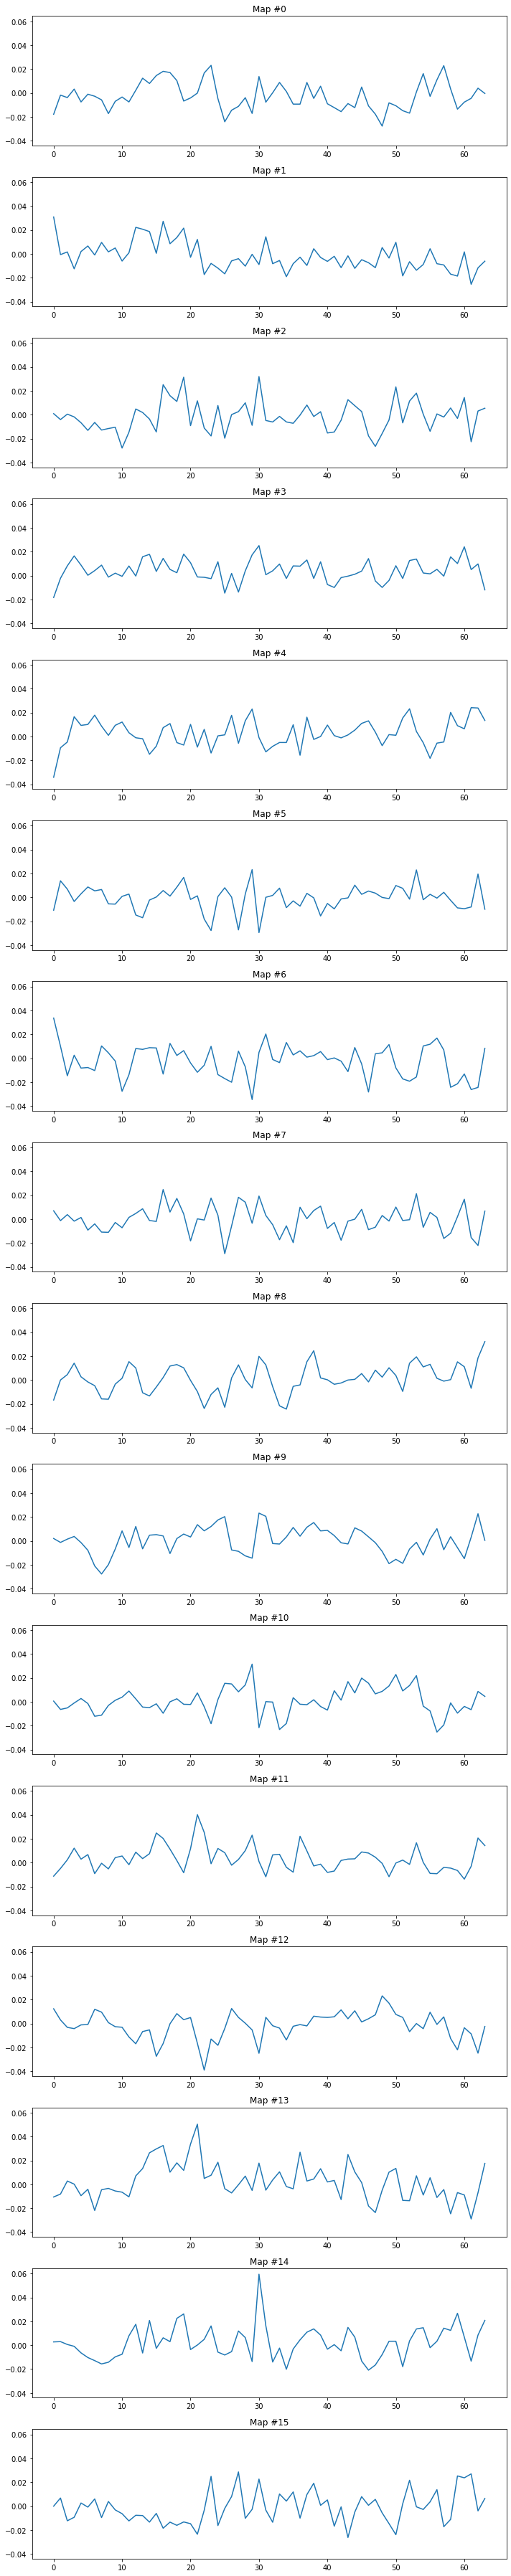

In [44]:
# Two overlayed plots per subject and session (positive and negative feedback)
fig, axes = plt.subplots(16, 1, figsize=(10,50),sharex=False, sharey=True)

# Get data
layer = model.layer3[0]

for idx, map in enumerate(layer.weight):
  array = torch.mean(map, dim=0)
  array = array.view(-1).cpu().detach().numpy()
  axes[idx].plot(array)
  axes[idx].set_title("Map #{}".format(idx))

# plt.setp(axes[-1,:], xlabel="Time since feedback stimulus (ms)")
# plt.setp(axes[:,0], ylabel="Amplitude")
# fig.suptitle('Average negative/positive feedback signal (channel: {})\nPre-processing: {}'.format(channel_name, processing_metadata2str(filtered_metadata)), fontsize=16, weight='bold')
fig.tight_layout()
# fig.subplots_adjust(top=0.9)
fig.show()




In [39]:
model.layer3[0].weight.shape

torch.Size([16, 16, 64, 1])

In [41]:
torch.mean(model.layer3[0].weight, dim=1).shape

torch.Size([16, 64, 1])

# Tests

In [ ]:
DL = DataLoader(train_set, batch_size=7, num_workers=8, shuffle=False)
DL_iter = iter(DL)

In [ ]:
x, y = next(DL_iter)

In [ ]:
# x=x.float()
s = x.shape
print(s)

torch.Size([7, 2, 512])


In [ ]:
x = x[:,:,1:3]

In [ ]:
torch.empty(3, dtype=torch.long).random_(5)

tensor([4, 1, 2])

In [ ]:
y_logit = 5*(2*torch.rand([5,1])-1)
y_hat = torch.sigmoid(y_logit)
print(y_hat)
y_hat[y_hat>0.5] = 1
y_hat[y_hat<=0.5] = 0
print(y_hat)
print(y_hat.sum())

tensor([[0.7520],
        [0.0158],
        [0.8946],
        [0.0799],
        [0.9829]])
tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.]])
tensor(3.)


In [ ]:
loss = nn.BCEWithLogitsLoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(input, target)
print("input:{}\ntarget:{}\noutput:{}".format(input, target, output))

input:tensor([-0.1470,  0.7771,  1.1536], requires_grad=True)
target:tensor([0., 1., 0.])
output:0.8094660639762878


In [ ]:
m = nn.Softmax(dim=-1)
i = torch.randn(2, 3)
o = m(i)
print("in:{}\nout:{}\n".format(i,o))

in:tensor([[ 1.2056,  0.2800, -1.0451],
        [-0.9154, -1.0824, -0.8079]])
out:tensor([[0.6660, 0.2639, 0.0701],
        [0.3379, 0.2859, 0.3762]])



In [ ]:
a = torch.tensor([1., 0., 1., 1., 0.])
b = torch.tensor([0., 1., 1., 0., 0.])

(b==a).sum().type(torch.float) / len(a)

tensor(0.4000)